# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [49]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [50]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [51]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_5127/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_5127/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_5127/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [43]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [52]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [53]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [77]:

hyperparameters= {
                "transformation": { "sigma_a": 0.1, "sigma_b": 5, "tau_a": 3, "tau_b": 0.7 },
                "decorrelation": { "sigma_a": 0.5, "sigma_b": 2, "tau_a": 1, "tau_b": 0.6 }
                }

model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=1,
    degree_transformations=3,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    inference = 'bayesian',
    device="cpu",
    hyperparameter=hyperparameters
    )
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [9]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [97]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=1.5,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

  0%|          | 1/1000 [00:00<04:17,  3.87it/s]

[1/1000] train=378.2914  val=384.4583  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0507  σmin=0.0507  σmax=0.0507


  0%|          | 2/1000 [00:00<03:55,  4.24it/s]

[2/1000] train=375.8953  val=380.7527  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0515  σmin=0.0515  σmax=0.0515


  0%|          | 3/1000 [00:00<03:50,  4.32it/s]

[3/1000] train=371.0526  val=377.0486  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0522  σmin=0.0522  σmax=0.0522


  0%|          | 4/1000 [00:00<03:47,  4.37it/s]

[4/1000] train=360.8599  val=373.3408  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 5/1000 [00:01<03:57,  4.19it/s]

[5/1000] train=367.0016  val=369.6367  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0538  σmin=0.0538  σmax=0.0538


  1%|          | 6/1000 [00:01<03:58,  4.17it/s]

[6/1000] train=371.6550  val=365.9318  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0546  σmin=0.0546  σmax=0.0546


  1%|          | 7/1000 [00:02<05:54,  2.80it/s]

[7/1000] train=357.4339  val=362.2332  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0554  σmin=0.0554  σmax=0.0554


  1%|          | 8/1000 [00:02<05:09,  3.21it/s]

[8/1000] train=360.7624  val=358.5356  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 9/1000 [00:02<04:42,  3.51it/s]

[9/1000] train=357.1980  val=354.8425  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0570  σmin=0.0570  σmax=0.0570


  1%|          | 10/1000 [00:02<04:35,  3.59it/s]

[10/1000] train=345.6827  val=351.1470  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0579  σmin=0.0579  σmax=0.0579


  1%|          | 11/1000 [00:02<04:27,  3.70it/s]

[11/1000] train=354.1972  val=347.4525  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0587  σmin=0.0587  σmax=0.0587


  1%|          | 12/1000 [00:03<04:19,  3.80it/s]

[12/1000] train=357.0043  val=343.7586  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|▏         | 13/1000 [00:03<04:09,  3.96it/s]

[13/1000] train=340.4924  val=340.0664  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0604  σmin=0.0604  σmax=0.0605


  1%|▏         | 14/1000 [00:03<04:00,  4.11it/s]

[14/1000] train=352.5609  val=336.3759  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0613  σmin=0.0613  σmax=0.0613


  2%|▏         | 15/1000 [00:03<03:53,  4.22it/s]

[15/1000] train=336.1292  val=332.6888  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0622  σmin=0.0622  σmax=0.0622


  2%|▏         | 16/1000 [00:04<03:55,  4.18it/s]

[16/1000] train=331.6013  val=329.0033  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0631  σmin=0.0631  σmax=0.0632


  2%|▏         | 17/1000 [00:04<03:47,  4.32it/s]

[17/1000] train=332.7450  val=325.3228  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0641  σmin=0.0640  σmax=0.0641


  2%|▏         | 18/1000 [00:04<03:51,  4.24it/s]

[18/1000] train=320.7586  val=321.6454  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0650  σmin=0.0650  σmax=0.0650


  2%|▏         | 19/1000 [00:04<03:47,  4.31it/s]

[19/1000] train=320.0179  val=317.9706  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0660  σmin=0.0659  σmax=0.0660


  2%|▏         | 20/1000 [00:05<03:46,  4.32it/s]

[20/1000] train=318.0577  val=314.2981  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 21/1000 [00:05<03:45,  4.33it/s]

[21/1000] train=305.8849  val=310.6268  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0679  σmin=0.0679  σmax=0.0679


  2%|▏         | 22/1000 [00:05<03:48,  4.28it/s]

[22/1000] train=309.8964  val=306.9570  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0689  σmin=0.0688  σmax=0.0689


  2%|▏         | 23/1000 [00:05<03:48,  4.27it/s]

[23/1000] train=309.9805  val=303.2881  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0699  σmin=0.0698  σmax=0.0699


  2%|▏         | 24/1000 [00:05<03:42,  4.39it/s]

[24/1000] train=298.3433  val=299.6203  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▎         | 25/1000 [00:06<03:45,  4.33it/s]

[25/1000] train=297.7138  val=295.9512  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0719  σmin=0.0719  σmax=0.0720


  3%|▎         | 26/1000 [00:06<04:22,  3.71it/s]

[26/1000] train=294.5356  val=292.2832  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0730  σmin=0.0729  σmax=0.0730


  3%|▎         | 27/1000 [00:06<04:22,  3.71it/s]

[27/1000] train=286.8632  val=288.6154  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0741  σmin=0.0740  σmax=0.0741


  3%|▎         | 28/1000 [00:07<04:20,  3.73it/s]

[28/1000] train=287.7989  val=284.9513  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0751  σmin=0.0750  σmax=0.0752


  3%|▎         | 29/1000 [00:07<06:28,  2.50it/s]

[29/1000] train=274.4009  val=281.2906  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0762  σmin=0.0761  σmax=0.0762


  3%|▎         | 30/1000 [00:08<06:45,  2.39it/s]

[30/1000] train=287.8551  val=277.6357  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0773  σmin=0.0772  σmax=0.0774


  3%|▎         | 31/1000 [00:08<06:27,  2.50it/s]

[31/1000] train=276.5542  val=273.9856  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0785  σmin=0.0783  σmax=0.0785


  3%|▎         | 32/1000 [00:09<08:01,  2.01it/s]

[32/1000] train=277.0886  val=270.3384  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0796  σmin=0.0794  σmax=0.0796


  3%|▎         | 33/1000 [00:09<07:09,  2.25it/s]

[33/1000] train=268.1667  val=266.6960  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0808  σmin=0.0806  σmax=0.0808


  3%|▎         | 34/1000 [00:10<07:10,  2.24it/s]

[34/1000] train=260.6903  val=263.0563  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0819  σmin=0.0818  σmax=0.0819


  4%|▎         | 35/1000 [00:10<06:49,  2.36it/s]

[35/1000] train=263.0232  val=259.4163  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0831  σmin=0.0829  σmax=0.0831


  4%|▎         | 36/1000 [00:10<06:13,  2.58it/s]

[36/1000] train=260.0658  val=255.7770  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0843  σmin=0.0841  σmax=0.0843


  4%|▎         | 37/1000 [00:11<05:38,  2.85it/s]

[37/1000] train=250.6667  val=252.1391  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0855  σmin=0.0853  σmax=0.0856


  4%|▍         | 38/1000 [00:11<05:10,  3.10it/s]

[38/1000] train=246.4633  val=248.5038  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0868  σmin=0.0866  σmax=0.0868


  4%|▍         | 39/1000 [00:11<04:52,  3.28it/s]

[39/1000] train=249.8554  val=244.8709  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0880  σmin=0.0878  σmax=0.0880


  4%|▍         | 40/1000 [00:11<04:40,  3.43it/s]

[40/1000] train=246.2133  val=241.2398  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0893  σmin=0.0891  σmax=0.0893


  4%|▍         | 41/1000 [00:12<04:32,  3.52it/s]

[41/1000] train=245.0592  val=237.6101  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0906  σmin=0.0904  σmax=0.0906


  4%|▍         | 42/1000 [00:12<04:37,  3.45it/s]

[42/1000] train=244.5094  val=233.9813  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0919  σmin=0.0917  σmax=0.0919


  4%|▍         | 43/1000 [00:12<04:31,  3.52it/s]

[43/1000] train=233.5897  val=230.3578  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0932  σmin=0.0930  σmax=0.0933


  4%|▍         | 44/1000 [00:13<04:41,  3.39it/s]

[44/1000] train=217.8216  val=226.7384  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0946  σmin=0.0943  σmax=0.0946


  4%|▍         | 45/1000 [00:13<04:38,  3.43it/s]

[45/1000] train=224.9745  val=223.1255  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0959  σmin=0.0956  σmax=0.0960


  5%|▍         | 46/1000 [00:13<04:30,  3.53it/s]

[46/1000] train=228.2004  val=219.5171  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0973  σmin=0.0970  σmax=0.0973


  5%|▍         | 47/1000 [00:13<04:45,  3.33it/s]

[47/1000] train=214.9608  val=215.9119  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0987  σmin=0.0984  σmax=0.0988


  5%|▍         | 48/1000 [00:14<04:38,  3.41it/s]

[48/1000] train=218.7361  val=212.3095  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1001  σmin=0.0998  σmax=0.1002


  5%|▍         | 49/1000 [00:14<04:30,  3.51it/s]

[49/1000] train=209.1019  val=208.7115  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1016  σmin=0.1012  σmax=0.1016


  5%|▌         | 50/1000 [00:14<04:24,  3.59it/s]

[50/1000] train=206.4582  val=205.1153  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1030  σmin=0.1027  σmax=0.1031


  5%|▌         | 51/1000 [00:15<04:46,  3.31it/s]

[51/1000] train=205.5972  val=201.5219  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1045  σmin=0.1041  σmax=0.1046


  5%|▌         | 52/1000 [00:15<05:22,  2.94it/s]

[52/1000] train=199.0363  val=197.9316  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1060  σmin=0.1056  σmax=0.1061


  5%|▌         | 53/1000 [00:15<05:30,  2.87it/s]

[53/1000] train=197.8180  val=194.3430  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1075  σmin=0.1071  σmax=0.1076


  5%|▌         | 54/1000 [00:16<05:34,  2.83it/s]

[54/1000] train=194.0744  val=190.7586  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1091  σmin=0.1086  σmax=0.1091


  6%|▌         | 55/1000 [00:16<05:56,  2.65it/s]

[55/1000] train=189.5573  val=187.1766  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1106  σmin=0.1102  σmax=0.1107


  6%|▌         | 56/1000 [00:17<06:06,  2.58it/s]

[56/1000] train=181.5363  val=183.5957  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1122  σmin=0.1117  σmax=0.1123


  6%|▌         | 57/1000 [00:17<06:05,  2.58it/s]

[57/1000] train=175.1703  val=180.0177  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1138  σmin=0.1133  σmax=0.1139


  6%|▌         | 58/1000 [00:17<05:59,  2.62it/s]

[58/1000] train=179.4527  val=176.4419  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1154  σmin=0.1149  σmax=0.1155


  6%|▌         | 59/1000 [00:18<05:54,  2.66it/s]

[59/1000] train=176.4018  val=172.8705  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1171  σmin=0.1165  σmax=0.1172


  6%|▌         | 60/1000 [00:18<05:49,  2.69it/s]

[60/1000] train=167.3709  val=169.3027  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1188  σmin=0.1182  σmax=0.1188


  6%|▌         | 61/1000 [00:18<05:47,  2.70it/s]

[61/1000] train=163.4195  val=165.7409  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1204  σmin=0.1198  σmax=0.1205


  6%|▌         | 62/1000 [00:19<05:44,  2.72it/s]

[62/1000] train=161.9199  val=162.1848  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1222  σmin=0.1215  σmax=0.1223


  6%|▋         | 63/1000 [00:19<05:56,  2.63it/s]

[63/1000] train=159.3655  val=158.6348  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1239  σmin=0.1232  σmax=0.1240


  6%|▋         | 64/1000 [00:20<05:58,  2.61it/s]

[64/1000] train=154.7703  val=155.0890  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1257  σmin=0.1249  σmax=0.1258


  6%|▋         | 65/1000 [00:20<06:42,  2.32it/s]

[65/1000] train=155.1551  val=151.5457  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1274  σmin=0.1266  σmax=0.1276


  7%|▋         | 66/1000 [00:21<09:12,  1.69it/s]

[66/1000] train=149.2930  val=148.0038  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1292  σmin=0.1284  σmax=0.1294


  7%|▋         | 67/1000 [00:22<08:32,  1.82it/s]

[67/1000] train=148.4398  val=144.4631  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1311  σmin=0.1302  σmax=0.1312


  7%|▋         | 68/1000 [00:22<08:07,  1.91it/s]

[68/1000] train=146.6345  val=140.9274  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1329  σmin=0.1320  σmax=0.1331


  7%|▋         | 69/1000 [00:22<07:50,  1.98it/s]

[69/1000] train=134.8683  val=137.3944  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1348  σmin=0.1338  σmax=0.1350


  7%|▋         | 70/1000 [00:23<08:43,  1.78it/s]

[70/1000] train=132.9391  val=133.8666  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1367  σmin=0.1357  σmax=0.1369


  7%|▋         | 71/1000 [00:24<10:42,  1.45it/s]

[71/1000] train=129.4829  val=130.3455  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1386  σmin=0.1375  σmax=0.1388


  7%|▋         | 72/1000 [00:25<09:36,  1.61it/s]

[72/1000] train=128.5593  val=126.8317  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1406  σmin=0.1394  σmax=0.1408


  7%|▋         | 73/1000 [00:25<08:29,  1.82it/s]

[73/1000] train=123.1660  val=123.3221  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1426  σmin=0.1413  σmax=0.1428


  7%|▋         | 74/1000 [00:25<08:13,  1.88it/s]

[74/1000] train=121.6660  val=119.8160  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1446  σmin=0.1433  σmax=0.1448


  8%|▊         | 75/1000 [00:26<08:31,  1.81it/s]

[75/1000] train=117.7545  val=116.3170  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1466  σmin=0.1452  σmax=0.1468


  8%|▊         | 76/1000 [00:27<09:36,  1.60it/s]

[76/1000] train=112.1319  val=112.8237  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1487  σmin=0.1471  σmax=0.1489


  8%|▊         | 77/1000 [00:28<09:58,  1.54it/s]

[77/1000] train=113.6172  val=109.3358  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1507  σmin=0.1491  σmax=0.1510


  8%|▊         | 78/1000 [00:28<09:57,  1.54it/s]

[78/1000] train=108.7886  val=105.8525  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1529  σmin=0.1511  σmax=0.1531


  8%|▊         | 79/1000 [00:29<09:52,  1.55it/s]

[79/1000] train=102.2425  val=102.3751  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1550  σmin=0.1531  σmax=0.1553


  8%|▊         | 80/1000 [00:29<09:38,  1.59it/s]

[80/1000] train=102.4048  val=98.9036  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1572  σmin=0.1552  σmax=0.1575


  8%|▊         | 81/1000 [00:30<09:36,  1.59it/s]

[81/1000] train=94.7126  val=95.4356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1593  σmin=0.1573  σmax=0.1597


  8%|▊         | 82/1000 [00:31<09:25,  1.62it/s]

[82/1000] train=90.4231  val=91.9734  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1616  σmin=0.1594  σmax=0.1619


  8%|▊         | 83/1000 [00:31<09:31,  1.60it/s]

[83/1000] train=92.1714  val=88.5132  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1638  σmin=0.1615  σmax=0.1642


  8%|▊         | 84/1000 [00:32<09:38,  1.58it/s]

[84/1000] train=84.4984  val=85.0562  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1661  σmin=0.1636  σmax=0.1665


  8%|▊         | 85/1000 [00:33<09:42,  1.57it/s]

[85/1000] train=83.1095  val=81.6031  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1684  σmin=0.1658  σmax=0.1688


  9%|▊         | 86/1000 [00:34<13:07,  1.16it/s]

[86/1000] train=77.5590  val=78.1556  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1707  σmin=0.1680  σmax=0.1712


  9%|▊         | 87/1000 [00:35<15:15,  1.00s/it]

[87/1000] train=74.9714  val=74.7136  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1731  σmin=0.1702  σmax=0.1736


  9%|▉         | 88/1000 [00:36<13:29,  1.13it/s]

[88/1000] train=72.1125  val=71.2787  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1755  σmin=0.1725  σmax=0.1760


  9%|▉         | 89/1000 [00:37<12:23,  1.23it/s]

[89/1000] train=70.8845  val=67.8481  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1779  σmin=0.1747  σmax=0.1785


  9%|▉         | 90/1000 [00:37<11:39,  1.30it/s]

[90/1000] train=64.3601  val=64.4228  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1804  σmin=0.1770  σmax=0.1809


  9%|▉         | 91/1000 [00:38<10:57,  1.38it/s]

[91/1000] train=62.8126  val=61.0081  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1829  σmin=0.1793  σmax=0.1835


  9%|▉         | 92/1000 [00:38<10:30,  1.44it/s]

[92/1000] train=60.3037  val=57.6004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1854  σmin=0.1817  σmax=0.1860


  9%|▉         | 93/1000 [00:39<10:16,  1.47it/s]

[93/1000] train=54.7487  val=54.1998  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1880  σmin=0.1841  σmax=0.1886


  9%|▉         | 94/1000 [00:40<10:06,  1.49it/s]

[94/1000] train=55.6409  val=50.8087  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1905  σmin=0.1864  σmax=0.1912


 10%|▉         | 95/1000 [00:40<09:38,  1.57it/s]

[95/1000] train=46.8932  val=47.4182  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1932  σmin=0.1889  σmax=0.1939


 10%|▉         | 96/1000 [00:41<09:40,  1.56it/s]

[96/1000] train=46.7679  val=44.0341  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1958  σmin=0.1913  σmax=0.1966


 10%|▉         | 97/1000 [00:42<10:27,  1.44it/s]

[97/1000] train=44.4766  val=40.6528  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1985  σmin=0.1938  σmax=0.1993


 10%|▉         | 98/1000 [00:42<10:10,  1.48it/s]

[98/1000] train=37.3231  val=37.2761  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2012  σmin=0.1962  σmax=0.2020


 10%|▉         | 99/1000 [00:43<09:45,  1.54it/s]

[99/1000] train=37.5753  val=33.9004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2039  σmin=0.1987  σmax=0.2048


 10%|█         | 100/1000 [00:44<09:35,  1.56it/s]

[100/1000] train=32.8060  val=30.5330  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2067  σmin=0.2012  σmax=0.2076


 10%|█         | 101/1000 [00:44<09:15,  1.62it/s]

[101/1000] train=28.3774  val=27.1704  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2095  σmin=0.2038  σmax=0.2105


 10%|█         | 102/1000 [00:45<09:03,  1.65it/s]

[102/1000] train=25.2518  val=23.8139  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2124  σmin=0.2063  σmax=0.2134


 10%|█         | 103/1000 [00:45<08:55,  1.68it/s]

[103/1000] train=20.3691  val=20.4684  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2153  σmin=0.2088  σmax=0.2163


 10%|█         | 104/1000 [00:46<09:14,  1.62it/s]

[104/1000] train=20.8708  val=17.1312  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2182  σmin=0.2114  σmax=0.2193


 10%|█         | 105/1000 [00:47<09:43,  1.53it/s]

[105/1000] train=14.3445  val=13.8055  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2211  σmin=0.2139  σmax=0.2223


 11%|█         | 106/1000 [00:47<09:40,  1.54it/s]

[106/1000] train=11.0385  val=10.4915  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2241  σmin=0.2165  σmax=0.2254


 11%|█         | 107/1000 [00:48<09:32,  1.56it/s]

[107/1000] train=8.3105  val=7.1832  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2271  σmin=0.2191  σmax=0.2284


 11%|█         | 108/1000 [00:49<09:17,  1.60it/s]

[108/1000] train=3.1983  val=3.8832  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2302  σmin=0.2217  σmax=0.2316


 11%|█         | 109/1000 [00:49<09:00,  1.65it/s]

[109/1000] train=2.8240  val=0.5945  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2333  σmin=0.2244  σmax=0.2347


 11%|█         | 110/1000 [00:50<08:48,  1.68it/s]

[110/1000] train=0.7020  val=-2.6840  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2364  σmin=0.2271  σmax=0.2379


 11%|█         | 111/1000 [00:50<08:40,  1.71it/s]

[111/1000] train=-3.0957  val=-5.9608  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2396  σmin=0.2298  σmax=0.2412


 11%|█         | 112/1000 [00:51<08:34,  1.73it/s]

[112/1000] train=-6.2745  val=-9.2221  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2428  σmin=0.2325  σmax=0.2444


 11%|█▏        | 113/1000 [00:51<08:30,  1.74it/s]

[113/1000] train=-9.6094  val=-12.4704  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2460  σmin=0.2351  σmax=0.2478


 11%|█▏        | 114/1000 [00:52<08:32,  1.73it/s]

[114/1000] train=-12.4631  val=-15.7148  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2493  σmin=0.2379  σmax=0.2511


 12%|█▏        | 115/1000 [00:53<08:31,  1.73it/s]

[115/1000] train=-17.8051  val=-18.9475  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2526  σmin=0.2407  σmax=0.2545


 12%|█▏        | 116/1000 [00:53<08:27,  1.74it/s]

[116/1000] train=-19.6908  val=-22.1682  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2560  σmin=0.2435  σmax=0.2580


 12%|█▏        | 117/1000 [00:54<08:28,  1.74it/s]

[117/1000] train=-23.3916  val=-25.3834  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2593  σmin=0.2463  σmax=0.2614


 12%|█▏        | 118/1000 [00:54<08:22,  1.76it/s]

[118/1000] train=-26.7075  val=-28.6060  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2628  σmin=0.2491  σmax=0.2650


 12%|█▏        | 119/1000 [00:55<08:18,  1.77it/s]

[119/1000] train=-29.5065  val=-31.8267  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2662  σmin=0.2520  σmax=0.2685


 12%|█▏        | 120/1000 [00:55<08:17,  1.77it/s]

[120/1000] train=-34.8597  val=-35.0428  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2697  σmin=0.2550  σmax=0.2722


 12%|█▏        | 121/1000 [00:56<08:15,  1.77it/s]

[121/1000] train=-36.9008  val=-38.2457  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2733  σmin=0.2579  σmax=0.2758


 12%|█▏        | 122/1000 [00:57<08:11,  1.79it/s]

[122/1000] train=-39.9472  val=-41.4448  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2769  σmin=0.2609  σmax=0.2795


 12%|█▏        | 123/1000 [00:57<08:12,  1.78it/s]

[123/1000] train=-42.9853  val=-44.6316  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2805  σmin=0.2639  σmax=0.2833


 12%|█▏        | 124/1000 [00:58<08:07,  1.80it/s]

[124/1000] train=-48.7113  val=-47.8130  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2841  σmin=0.2669  σmax=0.2870


 12%|█▎        | 125/1000 [00:58<08:02,  1.81it/s]

[125/1000] train=-51.5857  val=-50.9787  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2878  σmin=0.2700  σmax=0.2909


 13%|█▎        | 126/1000 [00:59<07:59,  1.82it/s]

[126/1000] train=-51.0817  val=-54.1326  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2916  σmin=0.2729  σmax=0.2948


 13%|█▎        | 127/1000 [00:59<08:35,  1.69it/s]

[127/1000] train=-55.5132  val=-57.2737  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2954  σmin=0.2759  σmax=0.2987


 13%|█▎        | 128/1000 [01:00<08:23,  1.73it/s]

[128/1000] train=-59.0747  val=-60.4049  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2992  σmin=0.2788  σmax=0.3026


 13%|█▎        | 129/1000 [01:01<08:16,  1.75it/s]

[129/1000] train=-60.3819  val=-63.5165  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3030  σmin=0.2818  σmax=0.3067


 13%|█▎        | 130/1000 [01:01<08:12,  1.77it/s]

[130/1000] train=-65.8798  val=-66.6250  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3069  σmin=0.2848  σmax=0.3107


 13%|█▎        | 131/1000 [01:02<08:09,  1.78it/s]

[131/1000] train=-71.9009  val=-69.7299  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3109  σmin=0.2878  σmax=0.3148


 13%|█▎        | 132/1000 [01:02<08:07,  1.78it/s]

[132/1000] train=-69.5892  val=-72.8265  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3149  σmin=0.2908  σmax=0.3190


 13%|█▎        | 133/1000 [01:03<08:11,  1.76it/s]

[133/1000] train=-77.4648  val=-75.9119  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3189  σmin=0.2938  σmax=0.3232


 13%|█▎        | 134/1000 [01:03<08:09,  1.77it/s]

[134/1000] train=-75.3461  val=-78.9926  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3230  σmin=0.2968  σmax=0.3275


 14%|█▎        | 135/1000 [01:04<08:15,  1.75it/s]

[135/1000] train=-76.7433  val=-82.0666  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3271  σmin=0.2998  σmax=0.3318


 14%|█▎        | 136/1000 [01:05<08:16,  1.74it/s]

[136/1000] train=-79.5154  val=-85.1229  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3313  σmin=0.3030  σmax=0.3361


 14%|█▎        | 137/1000 [01:05<09:26,  1.52it/s]

[137/1000] train=-84.6442  val=-88.1732  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3355  σmin=0.3061  σmax=0.3405


 14%|█▍        | 138/1000 [01:06<09:02,  1.59it/s]

[138/1000] train=-91.8936  val=-91.2061  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3397  σmin=0.3092  σmax=0.3450


 14%|█▍        | 139/1000 [01:06<08:44,  1.64it/s]

[139/1000] train=-89.8300  val=-94.2270  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3440  σmin=0.3123  σmax=0.3495


 14%|█▍        | 140/1000 [01:07<08:31,  1.68it/s]

[140/1000] train=-97.2720  val=-97.2236  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3483  σmin=0.3151  σmax=0.3540


 14%|█▍        | 141/1000 [01:08<08:23,  1.70it/s]

[141/1000] train=-98.0160  val=-100.2133  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3527  σmin=0.3179  σmax=0.3586


 14%|█▍        | 142/1000 [01:08<08:19,  1.72it/s]

[142/1000] train=-102.4944  val=-103.1883  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3571  σmin=0.3208  σmax=0.3633


 14%|█▍        | 143/1000 [01:09<08:15,  1.73it/s]

[143/1000] train=-100.6353  val=-106.1636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3615  σmin=0.3236  σmax=0.3680


 14%|█▍        | 144/1000 [01:09<08:10,  1.75it/s]

[144/1000] train=-108.6555  val=-109.1350  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3660  σmin=0.3264  σmax=0.3728


 14%|█▍        | 145/1000 [01:10<08:05,  1.76it/s]

[145/1000] train=-113.5049  val=-112.0869  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3706  σmin=0.3293  σmax=0.3776


 15%|█▍        | 146/1000 [01:10<08:02,  1.77it/s]

[146/1000] train=-113.3734  val=-115.0434  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3752  σmin=0.3321  σmax=0.3824


 15%|█▍        | 147/1000 [01:11<08:02,  1.77it/s]

[147/1000] train=-115.6021  val=-117.9942  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3798  σmin=0.3350  σmax=0.3874


 15%|█▍        | 148/1000 [01:12<08:02,  1.77it/s]

[148/1000] train=-120.4617  val=-120.9288  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3845  σmin=0.3379  σmax=0.3923


 15%|█▍        | 149/1000 [01:12<08:01,  1.77it/s]

[149/1000] train=-123.8765  val=-123.8551  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3892  σmin=0.3408  σmax=0.3973


 15%|█▌        | 150/1000 [01:13<08:00,  1.77it/s]

[150/1000] train=-124.3023  val=-126.7681  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3939  σmin=0.3437  σmax=0.4024


 15%|█▌        | 151/1000 [01:13<07:58,  1.77it/s]

[151/1000] train=-126.9974  val=-129.6724  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3987  σmin=0.3466  σmax=0.4076


 15%|█▌        | 152/1000 [01:14<07:58,  1.77it/s]

[152/1000] train=-131.2829  val=-132.5645  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4036  σmin=0.3496  σmax=0.4127


 15%|█▌        | 153/1000 [01:14<07:56,  1.78it/s]

[153/1000] train=-137.8596  val=-135.4378  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4085  σmin=0.3525  σmax=0.4180


 15%|█▌        | 154/1000 [01:15<07:56,  1.78it/s]

[154/1000] train=-139.8643  val=-138.2962  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4134  σmin=0.3555  σmax=0.4233


 16%|█▌        | 155/1000 [01:16<07:57,  1.77it/s]

[155/1000] train=-137.6745  val=-141.1385  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4184  σmin=0.3584  σmax=0.4286


 16%|█▌        | 156/1000 [01:16<07:58,  1.76it/s]

[156/1000] train=-142.5408  val=-143.9519  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4234  σmin=0.3613  σmax=0.4340


 16%|█▌        | 157/1000 [01:17<07:54,  1.78it/s]

[157/1000] train=-144.6040  val=-146.7559  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4284  σmin=0.3640  σmax=0.4395


 16%|█▌        | 158/1000 [01:17<07:51,  1.78it/s]

[158/1000] train=-146.8036  val=-149.5309  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4336  σmin=0.3666  σmax=0.4450


 16%|█▌        | 159/1000 [01:18<07:50,  1.79it/s]

[159/1000] train=-150.6114  val=-152.2990  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4387  σmin=0.3693  σmax=0.4506


 16%|█▌        | 160/1000 [01:18<07:49,  1.79it/s]

[160/1000] train=-153.6932  val=-155.0552  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4439  σmin=0.3721  σmax=0.4562


 16%|█▌        | 161/1000 [01:19<07:48,  1.79it/s]

[161/1000] train=-152.1337  val=-157.8028  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4491  σmin=0.3749  σmax=0.4619


 16%|█▌        | 162/1000 [01:19<07:46,  1.80it/s]

[162/1000] train=-157.0725  val=-160.5464  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4544  σmin=0.3777  σmax=0.4676


 16%|█▋        | 163/1000 [01:20<07:50,  1.78it/s]

[163/1000] train=-157.1123  val=-163.2772  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4597  σmin=0.3804  σmax=0.4734


 16%|█▋        | 164/1000 [01:21<07:56,  1.75it/s]

[164/1000] train=-167.0890  val=-166.0000  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4651  σmin=0.3832  σmax=0.4792


 16%|█▋        | 165/1000 [01:21<07:57,  1.75it/s]

[165/1000] train=-165.7464  val=-168.7161  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4705  σmin=0.3860  σmax=0.4851


 17%|█▋        | 166/1000 [01:22<07:52,  1.76it/s]

[166/1000] train=-168.9661  val=-171.4334  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4759  σmin=0.3890  σmax=0.4911


 17%|█▋        | 167/1000 [01:22<07:49,  1.78it/s]

[167/1000] train=-173.9151  val=-174.1262  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4814  σmin=0.3918  σmax=0.4971


 17%|█▋        | 168/1000 [01:23<07:44,  1.79it/s]

[168/1000] train=-174.9301  val=-176.8208  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4869  σmin=0.3947  σmax=0.5032


 17%|█▋        | 169/1000 [01:23<07:40,  1.80it/s]

[169/1000] train=-178.2249  val=-179.5259  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4925  σmin=0.3977  σmax=0.5093


 17%|█▋        | 170/1000 [01:24<07:39,  1.81it/s]

[170/1000] train=-184.0577  val=-182.2190  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4981  σmin=0.4005  σmax=0.5155


 17%|█▋        | 171/1000 [01:24<07:35,  1.82it/s]

[171/1000] train=-181.0309  val=-184.8981  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5037  σmin=0.4019  σmax=0.5217


 17%|█▋        | 172/1000 [01:25<07:37,  1.81it/s]

[172/1000] train=-187.0495  val=-187.5626  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5094  σmin=0.4034  σmax=0.5280


 17%|█▋        | 173/1000 [01:26<07:41,  1.79it/s]

[173/1000] train=-189.8102  val=-190.2061  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5151  σmin=0.4050  σmax=0.5344


 17%|█▋        | 174/1000 [01:26<07:39,  1.80it/s]

[174/1000] train=-192.4114  val=-192.8399  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5208  σmin=0.4068  σmax=0.5408


 18%|█▊        | 175/1000 [01:27<07:40,  1.79it/s]

[175/1000] train=-191.4638  val=-195.4465  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5267  σmin=0.4087  σmax=0.5473


 18%|█▊        | 176/1000 [01:27<07:39,  1.79it/s]

[176/1000] train=-195.7131  val=-198.0365  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5325  σmin=0.4106  σmax=0.5538


 18%|█▊        | 177/1000 [01:28<07:39,  1.79it/s]

[177/1000] train=-201.1679  val=-200.6053  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5384  σmin=0.4125  σmax=0.5604


 18%|█▊        | 178/1000 [01:28<07:38,  1.79it/s]

[178/1000] train=-203.5813  val=-203.1743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5443  σmin=0.4143  σmax=0.5670


 18%|█▊        | 179/1000 [01:29<07:38,  1.79it/s]

[179/1000] train=-200.3470  val=-205.7278  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5503  σmin=0.4163  σmax=0.5737


 18%|█▊        | 180/1000 [01:29<07:37,  1.79it/s]

[180/1000] train=-204.7318  val=-208.2696  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5563  σmin=0.4183  σmax=0.5805


 18%|█▊        | 181/1000 [01:30<07:37,  1.79it/s]

[181/1000] train=-207.2066  val=-210.8022  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5623  σmin=0.4204  σmax=0.5873


 18%|█▊        | 182/1000 [01:31<07:36,  1.79it/s]

[182/1000] train=-208.5053  val=-213.3468  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5684  σmin=0.4223  σmax=0.5941


 18%|█▊        | 183/1000 [01:31<07:36,  1.79it/s]

[183/1000] train=-215.5483  val=-215.8696  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5746  σmin=0.4242  σmax=0.6011


 18%|█▊        | 184/1000 [01:32<07:35,  1.79it/s]

[184/1000] train=-215.8174  val=-218.3720  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5807  σmin=0.4260  σmax=0.6081


 18%|█▊        | 185/1000 [01:32<07:37,  1.78it/s]

[185/1000] train=-216.6122  val=-220.8707  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5870  σmin=0.4280  σmax=0.6151


 19%|█▊        | 186/1000 [01:33<07:37,  1.78it/s]

[186/1000] train=-221.7023  val=-223.3640  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5932  σmin=0.4300  σmax=0.6222


 19%|█▊        | 187/1000 [01:33<07:36,  1.78it/s]

[187/1000] train=-222.0006  val=-225.8498  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5995  σmin=0.4321  σmax=0.6294


 19%|█▉        | 188/1000 [01:34<07:38,  1.77it/s]

[188/1000] train=-226.6901  val=-228.3315  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6059  σmin=0.4344  σmax=0.6366


 19%|█▉        | 189/1000 [01:35<07:38,  1.77it/s]

[189/1000] train=-229.1784  val=-230.7966  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6123  σmin=0.4369  σmax=0.6439


 19%|█▉        | 190/1000 [01:35<07:38,  1.77it/s]

[190/1000] train=-229.6967  val=-233.2506  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6187  σmin=0.4384  σmax=0.6513


 19%|█▉        | 191/1000 [01:36<07:38,  1.76it/s]

[191/1000] train=-232.5167  val=-235.7089  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6252  σmin=0.4397  σmax=0.6587


 19%|█▉        | 192/1000 [01:36<07:38,  1.76it/s]

[192/1000] train=-236.3321  val=-238.1437  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6318  σmin=0.4412  σmax=0.6661


 19%|█▉        | 193/1000 [01:37<07:38,  1.76it/s]

[193/1000] train=-235.8050  val=-240.5251  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6383  σmin=0.4427  σmax=0.6736


 19%|█▉        | 194/1000 [01:37<07:37,  1.76it/s]

[194/1000] train=-239.5554  val=-242.8891  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6449  σmin=0.4445  σmax=0.6812


 20%|█▉        | 195/1000 [01:38<07:37,  1.76it/s]

[195/1000] train=-242.9176  val=-245.2545  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6515  σmin=0.4464  σmax=0.6888


 20%|█▉        | 196/1000 [01:39<07:37,  1.76it/s]

[196/1000] train=-246.5690  val=-247.6189  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6582  σmin=0.4480  σmax=0.6965


 20%|█▉        | 197/1000 [01:39<07:40,  1.74it/s]

[197/1000] train=-246.2133  val=-249.9791  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6649  σmin=0.4496  σmax=0.7042


 20%|█▉        | 198/1000 [01:40<07:37,  1.75it/s]

[198/1000] train=-247.4096  val=-252.3308  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6717  σmin=0.4516  σmax=0.7120


 20%|█▉        | 199/1000 [01:40<07:34,  1.76it/s]

[199/1000] train=-252.6960  val=-254.6622  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6785  σmin=0.4537  σmax=0.7199


 20%|██        | 200/1000 [01:41<07:36,  1.75it/s]

[200/1000] train=-256.6357  val=-256.9840  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6853  σmin=0.4558  σmax=0.7278


 20%|██        | 201/1000 [01:41<07:39,  1.74it/s]

[201/1000] train=-254.1324  val=-259.3091  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6922  σmin=0.4575  σmax=0.7358


 20%|██        | 202/1000 [01:42<07:38,  1.74it/s]

[202/1000] train=-261.0532  val=-261.6200  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6991  σmin=0.4586  σmax=0.7439


 20%|██        | 203/1000 [01:43<07:35,  1.75it/s]

[203/1000] train=-264.4744  val=-263.9274  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7061  σmin=0.4598  σmax=0.7519


 20%|██        | 204/1000 [01:43<07:31,  1.76it/s]

[204/1000] train=-262.5854  val=-266.2474  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7131  σmin=0.4609  σmax=0.7601


 20%|██        | 205/1000 [01:44<07:44,  1.71it/s]

[205/1000] train=-269.3627  val=-268.5552  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7201  σmin=0.4622  σmax=0.7683


 21%|██        | 206/1000 [01:44<07:36,  1.74it/s]

[206/1000] train=-265.7858  val=-270.8295  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7272  σmin=0.4636  σmax=0.7765


 21%|██        | 207/1000 [01:45<07:30,  1.76it/s]

[207/1000] train=-269.8276  val=-273.0988  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7343  σmin=0.4649  σmax=0.7848


 21%|██        | 208/1000 [01:45<07:26,  1.77it/s]

[208/1000] train=-274.6023  val=-275.3606  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7414  σmin=0.4666  σmax=0.7931


 21%|██        | 209/1000 [01:46<07:24,  1.78it/s]

[209/1000] train=-278.8652  val=-277.6046  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7486  σmin=0.4680  σmax=0.8015


 21%|██        | 210/1000 [01:46<07:21,  1.79it/s]

[210/1000] train=-278.3451  val=-279.8107  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7558  σmin=0.4692  σmax=0.8100


 21%|██        | 211/1000 [01:47<07:21,  1.79it/s]

[211/1000] train=-276.1651  val=-282.0111  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7631  σmin=0.4705  σmax=0.8185


 21%|██        | 212/1000 [01:48<07:18,  1.80it/s]

[212/1000] train=-283.3546  val=-284.2028  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7703  σmin=0.4720  σmax=0.8271


 21%|██▏       | 213/1000 [01:48<07:15,  1.81it/s]

[213/1000] train=-281.5710  val=-286.3805  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7777  σmin=0.4728  σmax=0.8357


 21%|██▏       | 214/1000 [01:49<07:11,  1.82it/s]

[214/1000] train=-289.1054  val=-288.5475  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7850  σmin=0.4732  σmax=0.8443


 22%|██▏       | 215/1000 [01:49<07:12,  1.81it/s]

[215/1000] train=-290.6411  val=-290.6898  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7924  σmin=0.4741  σmax=0.8530


 22%|██▏       | 216/1000 [01:50<07:13,  1.81it/s]

[216/1000] train=-287.1866  val=-292.8145  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7999  σmin=0.4745  σmax=0.8618


 22%|██▏       | 217/1000 [01:50<07:13,  1.81it/s]

[217/1000] train=-291.8360  val=-294.9369  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8074  σmin=0.4748  σmax=0.8707


 22%|██▏       | 218/1000 [01:51<07:14,  1.80it/s]

[218/1000] train=-294.4603  val=-297.0368  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8149  σmin=0.4749  σmax=0.8796


 22%|██▏       | 219/1000 [01:51<07:16,  1.79it/s]

[219/1000] train=-298.0599  val=-299.1285  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8225  σmin=0.4747  σmax=0.8885


 22%|██▏       | 220/1000 [01:52<07:16,  1.79it/s]

[220/1000] train=-298.5770  val=-301.2288  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8301  σmin=0.4747  σmax=0.8975


 22%|██▏       | 221/1000 [01:53<07:16,  1.79it/s]

[221/1000] train=-300.8353  val=-303.3253  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8377  σmin=0.4748  σmax=0.9066


 22%|██▏       | 222/1000 [01:53<07:14,  1.79it/s]

[222/1000] train=-308.0666  val=-305.4085  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8454  σmin=0.4748  σmax=0.9157


 22%|██▏       | 223/1000 [01:54<07:16,  1.78it/s]

[223/1000] train=-310.3728  val=-307.4767  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8531  σmin=0.4745  σmax=0.9248


 22%|██▏       | 224/1000 [01:54<07:19,  1.77it/s]

[224/1000] train=-303.2802  val=-309.5574  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8608  σmin=0.4740  σmax=0.9340


 22%|██▎       | 225/1000 [01:55<07:21,  1.76it/s]

[225/1000] train=-312.2774  val=-311.6414  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8686  σmin=0.4738  σmax=0.9433


 23%|██▎       | 226/1000 [01:55<07:20,  1.76it/s]

[226/1000] train=-310.2603  val=-313.7416  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8764  σmin=0.4740  σmax=0.9525


 23%|██▎       | 227/1000 [01:56<07:19,  1.76it/s]

[227/1000] train=-318.2525  val=-315.8526  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8843  σmin=0.4742  σmax=0.9619


 23%|██▎       | 228/1000 [01:57<07:18,  1.76it/s]

[228/1000] train=-317.0719  val=-317.9568  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8922  σmin=0.4748  σmax=0.9713


 23%|██▎       | 229/1000 [01:57<07:22,  1.74it/s]

[229/1000] train=-315.3963  val=-320.0415  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9001  σmin=0.4749  σmax=0.9808


 23%|██▎       | 230/1000 [01:58<07:20,  1.75it/s]

[230/1000] train=-318.2609  val=-322.1146  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9081  σmin=0.4742  σmax=0.9904


 23%|██▎       | 231/1000 [01:58<07:18,  1.75it/s]

[231/1000] train=-319.3988  val=-324.1799  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9161  σmin=0.4732  σmax=0.9999


 23%|██▎       | 232/1000 [01:59<07:15,  1.76it/s]

[232/1000] train=-323.5117  val=-326.2151  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9242  σmin=0.4721  σmax=1.0096


 23%|██▎       | 233/1000 [01:59<07:13,  1.77it/s]

[233/1000] train=-328.1277  val=-328.2289  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9323  σmin=0.4717  σmax=1.0193


 23%|██▎       | 234/1000 [02:00<07:14,  1.76it/s]

[234/1000] train=-328.3642  val=-330.2243  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9404  σmin=0.4716  σmax=1.0290


 24%|██▎       | 235/1000 [02:01<07:11,  1.77it/s]

[235/1000] train=-327.6494  val=-332.1906  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9485  σmin=0.4714  σmax=1.0388


 24%|██▎       | 236/1000 [02:01<07:14,  1.76it/s]

[236/1000] train=-330.7640  val=-334.1354  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9567  σmin=0.4712  σmax=1.0486


 24%|██▎       | 237/1000 [02:02<07:15,  1.75it/s]

[237/1000] train=-334.7908  val=-336.0533  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9649  σmin=0.4710  σmax=1.0585


 24%|██▍       | 238/1000 [02:02<07:17,  1.74it/s]

[238/1000] train=-336.7740  val=-337.9805  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9732  σmin=0.4713  σmax=1.0684


 24%|██▍       | 239/1000 [02:03<07:13,  1.75it/s]

[239/1000] train=-336.7812  val=-339.8863  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9815  σmin=0.4719  σmax=1.0784


 24%|██▍       | 240/1000 [02:03<07:10,  1.77it/s]

[240/1000] train=-339.0687  val=-341.7848  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9898  σmin=0.4729  σmax=1.0884


 24%|██▍       | 241/1000 [02:04<07:11,  1.76it/s]

[241/1000] train=-340.1301  val=-343.6877  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9982  σmin=0.4735  σmax=1.0984


 24%|██▍       | 242/1000 [02:05<07:10,  1.76it/s]

[242/1000] train=-343.4700  val=-345.5782  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0066  σmin=0.4740  σmax=1.1086


 24%|██▍       | 243/1000 [02:05<07:13,  1.75it/s]

[243/1000] train=-344.0585  val=-347.4836  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0150  σmin=0.4745  σmax=1.1187


 24%|██▍       | 244/1000 [02:06<07:16,  1.73it/s]

[244/1000] train=-346.3412  val=-349.3810  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0234  σmin=0.4750  σmax=1.1289


 24%|██▍       | 245/1000 [02:06<07:11,  1.75it/s]

[245/1000] train=-351.4400  val=-351.2801  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0319  σmin=0.4758  σmax=1.1391


 25%|██▍       | 246/1000 [02:07<07:07,  1.76it/s]

[246/1000] train=-351.9974  val=-353.1682  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0404  σmin=0.4759  σmax=1.1495


 25%|██▍       | 247/1000 [02:07<07:04,  1.77it/s]

[247/1000] train=-352.8784  val=-355.0575  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0490  σmin=0.4752  σmax=1.1598


 25%|██▍       | 248/1000 [02:08<07:03,  1.78it/s]

[248/1000] train=-352.1755  val=-356.9394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0576  σmin=0.4749  σmax=1.1702


 25%|██▍       | 249/1000 [02:09<07:00,  1.78it/s]

[249/1000] train=-357.8280  val=-358.8072  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0662  σmin=0.4746  σmax=1.1807


 25%|██▌       | 250/1000 [02:09<06:57,  1.80it/s]

[250/1000] train=-362.6044  val=-360.6719  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0749  σmin=0.4746  σmax=1.1912


 25%|██▌       | 251/1000 [02:10<06:57,  1.79it/s]

[251/1000] train=-360.9651  val=-362.5142  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0836  σmin=0.4746  σmax=1.2017


 25%|██▌       | 252/1000 [02:10<06:55,  1.80it/s]

[252/1000] train=-361.6179  val=-364.3471  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0924  σmin=0.4747  σmax=1.2123


 25%|██▌       | 253/1000 [02:11<06:53,  1.81it/s]

[253/1000] train=-364.0862  val=-366.1719  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1012  σmin=0.4750  σmax=1.2229


 25%|██▌       | 254/1000 [02:11<06:54,  1.80it/s]

[254/1000] train=-367.2082  val=-367.9912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1100  σmin=0.4753  σmax=1.2335


 26%|██▌       | 255/1000 [02:12<06:54,  1.80it/s]

[255/1000] train=-367.8010  val=-369.7936  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1189  σmin=0.4758  σmax=1.2443


 26%|██▌       | 256/1000 [02:12<06:51,  1.81it/s]

[256/1000] train=-369.6726  val=-371.5785  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1277  σmin=0.4767  σmax=1.2550


 26%|██▌       | 257/1000 [02:13<06:49,  1.81it/s]

[257/1000] train=-371.3252  val=-373.3420  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1367  σmin=0.4777  σmax=1.2658


 26%|██▌       | 258/1000 [02:13<06:49,  1.81it/s]

[258/1000] train=-374.4981  val=-375.1023  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1456  σmin=0.4793  σmax=1.2766


 26%|██▌       | 259/1000 [02:14<06:49,  1.81it/s]

[259/1000] train=-375.2828  val=-376.8407  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1546  σmin=0.4791  σmax=1.2875


 26%|██▌       | 260/1000 [02:15<06:49,  1.81it/s]

[260/1000] train=-377.2001  val=-378.5636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1636  σmin=0.4788  σmax=1.2984


 26%|██▌       | 261/1000 [02:15<06:51,  1.80it/s]

[261/1000] train=-377.4883  val=-380.2926  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1727  σmin=0.4784  σmax=1.3094


 26%|██▌       | 262/1000 [02:16<06:53,  1.79it/s]

[262/1000] train=-381.7226  val=-382.0113  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1818  σmin=0.4779  σmax=1.3204


 26%|██▋       | 263/1000 [02:16<06:53,  1.78it/s]

[263/1000] train=-384.1790  val=-383.7209  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1910  σmin=0.4778  σmax=1.3315


 26%|██▋       | 264/1000 [02:17<06:52,  1.79it/s]

[264/1000] train=-383.0914  val=-385.4108  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2002  σmin=0.4777  σmax=1.3426


 26%|██▋       | 265/1000 [02:18<07:24,  1.65it/s]

[265/1000] train=-383.5723  val=-387.0862  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2093  σmin=0.4773  σmax=1.3537


 27%|██▋       | 266/1000 [02:18<07:15,  1.69it/s]

[266/1000] train=-386.1604  val=-388.7766  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2185  σmin=0.4770  σmax=1.3648


 27%|██▋       | 267/1000 [02:19<07:07,  1.71it/s]

[267/1000] train=-388.0499  val=-390.4622  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2276  σmin=0.4767  σmax=1.3760


 27%|██▋       | 268/1000 [02:20<08:09,  1.50it/s]

[268/1000] train=-391.3388  val=-392.1547  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2368  σmin=0.4767  σmax=1.3871


 27%|██▋       | 269/1000 [02:20<07:53,  1.54it/s]

[269/1000] train=-392.1389  val=-393.8196  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2460  σmin=0.4757  σmax=1.3983


 27%|██▋       | 270/1000 [02:21<07:44,  1.57it/s]

[270/1000] train=-394.8044  val=-395.4607  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2552  σmin=0.4753  σmax=1.4095


 27%|██▋       | 271/1000 [02:21<07:33,  1.61it/s]

[271/1000] train=-396.0367  val=-397.0901  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2644  σmin=0.4746  σmax=1.4207


 27%|██▋       | 272/1000 [02:22<07:19,  1.66it/s]

[272/1000] train=-397.0641  val=-398.7154  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2736  σmin=0.4736  σmax=1.4319


 27%|██▋       | 273/1000 [02:22<07:10,  1.69it/s]

[273/1000] train=-398.2970  val=-400.3361  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2829  σmin=0.4729  σmax=1.4433


 27%|██▋       | 274/1000 [02:23<07:08,  1.70it/s]

[274/1000] train=-396.6174  val=-401.9699  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2922  σmin=0.4722  σmax=1.4546


 28%|██▊       | 275/1000 [02:24<07:02,  1.72it/s]

[275/1000] train=-403.1328  val=-403.5943  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3015  σmin=0.4712  σmax=1.4659


 28%|██▊       | 276/1000 [02:24<07:00,  1.72it/s]

[276/1000] train=-400.3607  val=-405.2271  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3108  σmin=0.4705  σmax=1.4773


 28%|██▊       | 277/1000 [02:25<06:57,  1.73it/s]

[277/1000] train=-404.6531  val=-406.8664  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3202  σmin=0.4702  σmax=1.4888


 28%|██▊       | 278/1000 [02:25<06:57,  1.73it/s]

[278/1000] train=-411.7408  val=-408.4756  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3296  σmin=0.4695  σmax=1.5002


 28%|██▊       | 279/1000 [02:26<06:53,  1.74it/s]

[279/1000] train=-408.4221  val=-410.0682  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3391  σmin=0.4696  σmax=1.5117


 28%|██▊       | 280/1000 [02:26<06:50,  1.75it/s]

[280/1000] train=-412.3720  val=-411.6572  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3485  σmin=0.4700  σmax=1.5232


 28%|██▊       | 281/1000 [02:27<07:18,  1.64it/s]

[281/1000] train=-412.8627  val=-413.2329  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3580  σmin=0.4702  σmax=1.5347


 28%|██▊       | 282/1000 [02:28<07:45,  1.54it/s]

[282/1000] train=-413.5287  val=-414.8028  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3675  σmin=0.4708  σmax=1.5462


 28%|██▊       | 283/1000 [02:29<09:30,  1.26it/s]

[283/1000] train=-416.5101  val=-416.3578  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3770  σmin=0.4717  σmax=1.5578


 28%|██▊       | 284/1000 [02:30<09:43,  1.23it/s]

[284/1000] train=-414.8212  val=-417.9151  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3866  σmin=0.4730  σmax=1.5695


 28%|██▊       | 285/1000 [02:32<13:44,  1.15s/it]

[285/1000] train=-416.8916  val=-419.4703  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3963  σmin=0.4738  σmax=1.5812


 29%|██▊       | 286/1000 [02:33<12:06,  1.02s/it]

[286/1000] train=-417.7061  val=-420.9884  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4058  σmin=0.4727  σmax=1.5929


 29%|██▊       | 287/1000 [02:33<10:39,  1.12it/s]

[287/1000] train=-421.1756  val=-422.5079  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4155  σmin=0.4718  σmax=1.6046


 29%|██▉       | 288/1000 [02:34<10:24,  1.14it/s]

[288/1000] train=-419.8055  val=-424.0250  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4251  σmin=0.4711  σmax=1.6164


 29%|██▉       | 289/1000 [02:35<11:30,  1.03it/s]

[289/1000] train=-424.8723  val=-425.5218  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4348  σmin=0.4703  σmax=1.6282


 29%|██▉       | 290/1000 [02:36<10:26,  1.13it/s]

[290/1000] train=-425.0052  val=-427.0106  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4445  σmin=0.4693  σmax=1.6400


 29%|██▉       | 291/1000 [02:37<09:40,  1.22it/s]

[291/1000] train=-424.8813  val=-428.4865  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4543  σmin=0.4684  σmax=1.6519


 29%|██▉       | 292/1000 [02:37<09:20,  1.26it/s]

[292/1000] train=-427.6963  val=-429.9541  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4641  σmin=0.4679  σmax=1.6638


 29%|██▉       | 293/1000 [02:38<09:12,  1.28it/s]

[293/1000] train=-426.0815  val=-431.4170  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4739  σmin=0.4679  σmax=1.6758


 29%|██▉       | 294/1000 [02:39<08:33,  1.38it/s]

[294/1000] train=-429.3539  val=-432.8618  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4837  σmin=0.4677  σmax=1.6878


 30%|██▉       | 295/1000 [02:39<08:03,  1.46it/s]

[295/1000] train=-435.0386  val=-434.3189  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4935  σmin=0.4676  σmax=1.6997


 30%|██▉       | 296/1000 [02:40<08:10,  1.43it/s]

[296/1000] train=-432.0058  val=-435.7663  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5033  σmin=0.4677  σmax=1.7117


 30%|██▉       | 297/1000 [02:41<07:51,  1.49it/s]

[297/1000] train=-438.7963  val=-437.2198  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5132  σmin=0.4677  σmax=1.7238


 30%|██▉       | 298/1000 [02:41<07:40,  1.53it/s]

[298/1000] train=-434.7061  val=-438.6650  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5232  σmin=0.4682  σmax=1.7359


 30%|██▉       | 299/1000 [02:42<07:25,  1.57it/s]

[299/1000] train=-434.6115  val=-440.0974  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5332  σmin=0.4684  σmax=1.7481


 30%|███       | 300/1000 [02:42<07:37,  1.53it/s]

[300/1000] train=-438.3180  val=-441.5528  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5431  σmin=0.4683  σmax=1.7603


 30%|███       | 301/1000 [02:43<07:52,  1.48it/s]

[301/1000] train=-443.6968  val=-443.0005  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5531  σmin=0.4687  σmax=1.7724


 30%|███       | 302/1000 [02:44<07:46,  1.50it/s]

[302/1000] train=-443.2697  val=-444.4377  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5631  σmin=0.4697  σmax=1.7846


 30%|███       | 303/1000 [02:45<07:53,  1.47it/s]

[303/1000] train=-448.5654  val=-445.8663  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5731  σmin=0.4708  σmax=1.7968


 30%|███       | 304/1000 [02:46<09:49,  1.18it/s]

[304/1000] train=-447.4518  val=-447.2758  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5831  σmin=0.4715  σmax=1.8091


 30%|███       | 305/1000 [02:46<08:55,  1.30it/s]

[305/1000] train=-450.7809  val=-448.6850  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5931  σmin=0.4727  σmax=1.8213


 31%|███       | 306/1000 [02:47<08:28,  1.36it/s]

[306/1000] train=-448.6689  val=-450.0842  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6031  σmin=0.4731  σmax=1.8336


 31%|███       | 307/1000 [02:48<08:08,  1.42it/s]

[307/1000] train=-450.1641  val=-451.4682  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6131  σmin=0.4724  σmax=1.8457


 31%|███       | 308/1000 [02:48<07:50,  1.47it/s]

[308/1000] train=-451.1456  val=-452.8268  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6231  σmin=0.4715  σmax=1.8579


 31%|███       | 309/1000 [02:49<07:35,  1.52it/s]

[309/1000] train=-457.9282  val=-454.1774  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6331  σmin=0.4703  σmax=1.8702


 31%|███       | 310/1000 [02:50<07:34,  1.52it/s]

[310/1000] train=-451.0178  val=-455.5354  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6431  σmin=0.4692  σmax=1.8824


 31%|███       | 311/1000 [02:50<07:25,  1.55it/s]

[311/1000] train=-454.3113  val=-456.8967  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6532  σmin=0.4675  σmax=1.8948


 31%|███       | 312/1000 [02:51<07:25,  1.54it/s]

[312/1000] train=-456.5814  val=-458.2513  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6633  σmin=0.4667  σmax=1.9071


 31%|███▏      | 313/1000 [02:51<07:15,  1.58it/s]

[313/1000] train=-460.2355  val=-459.6098  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6735  σmin=0.4654  σmax=1.9196


 31%|███▏      | 314/1000 [02:52<07:43,  1.48it/s]

[314/1000] train=-459.0319  val=-460.9444  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6837  σmin=0.4645  σmax=1.9320


 32%|███▏      | 315/1000 [02:53<07:27,  1.53it/s]

[315/1000] train=-460.5635  val=-462.2651  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6939  σmin=0.4631  σmax=1.9445


 32%|███▏      | 316/1000 [02:53<07:23,  1.54it/s]

[316/1000] train=-460.8118  val=-463.5667  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7042  σmin=0.4626  σmax=1.9570


 32%|███▏      | 317/1000 [02:54<07:20,  1.55it/s]

[317/1000] train=-460.4606  val=-464.8488  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7144  σmin=0.4618  σmax=1.9695


 32%|███▏      | 318/1000 [02:55<07:24,  1.53it/s]

[318/1000] train=-464.2452  val=-466.1205  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7246  σmin=0.4615  σmax=1.9819


 32%|███▏      | 319/1000 [02:55<07:13,  1.57it/s]

[319/1000] train=-465.6104  val=-467.3906  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7348  σmin=0.4618  σmax=1.9944


 32%|███▏      | 320/1000 [02:56<07:02,  1.61it/s]

[320/1000] train=-464.9467  val=-468.6570  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7450  σmin=0.4620  σmax=2.0068


 32%|███▏      | 321/1000 [02:56<06:54,  1.64it/s]

[321/1000] train=-467.5308  val=-469.9084  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7552  σmin=0.4621  σmax=2.0193


 32%|███▏      | 322/1000 [02:58<08:20,  1.35it/s]

[322/1000] train=-468.2207  val=-471.1499  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7654  σmin=0.4620  σmax=2.0318


 32%|███▏      | 323/1000 [02:58<08:25,  1.34it/s]

[323/1000] train=-469.4089  val=-472.3867  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7756  σmin=0.4621  σmax=2.0443


 32%|███▏      | 324/1000 [02:59<07:57,  1.42it/s]

[324/1000] train=-471.1048  val=-473.6240  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7858  σmin=0.4615  σmax=2.0567


 32%|███▎      | 325/1000 [03:00<08:10,  1.38it/s]

[325/1000] train=-475.3967  val=-474.8397  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7960  σmin=0.4614  σmax=2.0692


 33%|███▎      | 326/1000 [03:00<08:00,  1.40it/s]

[326/1000] train=-473.0560  val=-476.0515  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8062  σmin=0.4613  σmax=2.0817


 33%|███▎      | 327/1000 [03:01<07:39,  1.47it/s]

[327/1000] train=-478.2306  val=-477.2694  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8165  σmin=0.4613  σmax=2.0943


 33%|███▎      | 328/1000 [03:02<07:18,  1.53it/s]

[328/1000] train=-474.6334  val=-478.4838  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8268  σmin=0.4621  σmax=2.1069


 33%|███▎      | 329/1000 [03:02<07:09,  1.56it/s]

[329/1000] train=-478.3580  val=-479.6858  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8370  σmin=0.4622  σmax=2.1194


 33%|███▎      | 330/1000 [03:03<07:15,  1.54it/s]

[330/1000] train=-481.5144  val=-480.8997  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8472  σmin=0.4626  σmax=2.1320


 33%|███▎      | 331/1000 [03:03<07:14,  1.54it/s]

[331/1000] train=-481.6941  val=-482.1112  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8574  σmin=0.4632  σmax=2.1446


 33%|███▎      | 332/1000 [03:04<07:31,  1.48it/s]

[332/1000] train=-480.3148  val=-483.3218  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8677  σmin=0.4640  σmax=2.1572


 33%|███▎      | 333/1000 [03:05<09:03,  1.23it/s]

[333/1000] train=-483.5289  val=-484.5506  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8779  σmin=0.4650  σmax=2.1698


 33%|███▎      | 334/1000 [03:07<10:15,  1.08it/s]

[334/1000] train=-483.6697  val=-485.7842  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8883  σmin=0.4658  σmax=2.1825


 34%|███▎      | 335/1000 [03:08<10:49,  1.02it/s]

[335/1000] train=-486.5170  val=-487.0167  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8987  σmin=0.4664  σmax=2.1952


 34%|███▎      | 336/1000 [03:09<11:16,  1.02s/it]

[336/1000] train=-487.2057  val=-488.2276  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9090  σmin=0.4663  σmax=2.2079


 34%|███▎      | 337/1000 [03:10<10:40,  1.04it/s]

[337/1000] train=-485.3273  val=-489.4132  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9193  σmin=0.4673  σmax=2.2205


 34%|███▍      | 338/1000 [03:11<11:27,  1.04s/it]

[338/1000] train=-488.9380  val=-490.5776  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9296  σmin=0.4687  σmax=2.2332


 34%|███▍      | 339/1000 [03:12<10:39,  1.03it/s]

[339/1000] train=-492.7806  val=-491.7540  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9400  σmin=0.4700  σmax=2.2458


 34%|███▍      | 340/1000 [03:12<09:45,  1.13it/s]

[340/1000] train=-489.1184  val=-492.9076  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9502  σmin=0.4689  σmax=2.2584


 34%|███▍      | 341/1000 [03:13<08:49,  1.25it/s]

[341/1000] train=-492.7575  val=-494.0220  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9604  σmin=0.4679  σmax=2.2709


 34%|███▍      | 342/1000 [03:14<08:08,  1.35it/s]

[342/1000] train=-490.1351  val=-495.1433  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9705  σmin=0.4669  σmax=2.2834


 34%|███▍      | 343/1000 [03:14<07:47,  1.41it/s]

[343/1000] train=-495.7699  val=-496.2468  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9807  σmin=0.4651  σmax=2.2958


 34%|███▍      | 344/1000 [03:15<07:24,  1.48it/s]

[344/1000] train=-495.7738  val=-497.3462  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9908  σmin=0.4636  σmax=2.3083


 34%|███▍      | 345/1000 [03:15<07:07,  1.53it/s]

[345/1000] train=-496.3055  val=-498.4346  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0010  σmin=0.4625  σmax=2.3208


 35%|███▍      | 346/1000 [03:16<06:58,  1.56it/s]

[346/1000] train=-498.0297  val=-499.5318  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0113  σmin=0.4609  σmax=2.3334


 35%|███▍      | 347/1000 [03:17<06:49,  1.59it/s]

[347/1000] train=-496.8730  val=-500.6310  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0216  σmin=0.4589  σmax=2.3460


 35%|███▍      | 348/1000 [03:17<06:43,  1.62it/s]

[348/1000] train=-502.9202  val=-501.7307  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0319  σmin=0.4574  σmax=2.3586


 35%|███▍      | 349/1000 [03:18<06:38,  1.63it/s]

[349/1000] train=-502.9294  val=-502.8266  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0422  σmin=0.4565  σmax=2.3713


 35%|███▌      | 350/1000 [03:18<06:36,  1.64it/s]

[350/1000] train=-500.4206  val=-503.9183  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0526  σmin=0.4557  σmax=2.3841


 35%|███▌      | 351/1000 [03:19<06:31,  1.66it/s]

[351/1000] train=-504.8362  val=-505.0209  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0630  σmin=0.4545  σmax=2.3968


 35%|███▌      | 352/1000 [03:20<06:32,  1.65it/s]

[352/1000] train=-508.3214  val=-506.1127  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0733  σmin=0.4537  σmax=2.4095


 35%|███▌      | 353/1000 [03:20<06:40,  1.62it/s]

[353/1000] train=-504.7452  val=-507.2040  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0837  σmin=0.4533  σmax=2.4222


 35%|███▌      | 354/1000 [03:21<06:58,  1.54it/s]

[354/1000] train=-507.8109  val=-508.2963  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0941  σmin=0.4534  σmax=2.4349


 36%|███▌      | 355/1000 [03:22<06:48,  1.58it/s]

[355/1000] train=-509.5330  val=-509.3870  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1044  σmin=0.4545  σmax=2.4476


 36%|███▌      | 356/1000 [03:22<06:38,  1.62it/s]

[356/1000] train=-509.0283  val=-510.4840  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1148  σmin=0.4557  σmax=2.4604


 36%|███▌      | 357/1000 [03:23<06:30,  1.65it/s]

[357/1000] train=-511.7165  val=-511.5748  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1251  σmin=0.4569  σmax=2.4730


 36%|███▌      | 358/1000 [03:23<06:24,  1.67it/s]

[358/1000] train=-511.1925  val=-512.6553  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1355  σmin=0.4582  σmax=2.4858


 36%|███▌      | 359/1000 [03:24<06:21,  1.68it/s]

[359/1000] train=-512.4967  val=-513.7177  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1459  σmin=0.4592  σmax=2.4986


 36%|███▌      | 360/1000 [03:24<06:18,  1.69it/s]

[360/1000] train=-516.3401  val=-514.7828  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1564  σmin=0.4608  σmax=2.5115


 36%|███▌      | 361/1000 [03:25<06:16,  1.70it/s]

[361/1000] train=-512.1628  val=-515.8216  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1669  σmin=0.4627  σmax=2.5243


 36%|███▌      | 362/1000 [03:26<06:15,  1.70it/s]

[362/1000] train=-515.1996  val=-516.8573  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1773  σmin=0.4648  σmax=2.5370


 36%|███▋      | 363/1000 [03:26<06:16,  1.69it/s]

[363/1000] train=-517.6255  val=-517.8779  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1876  σmin=0.4666  σmax=2.5497


 36%|███▋      | 364/1000 [03:27<06:29,  1.63it/s]

[364/1000] train=-516.7481  val=-518.8975  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.1978  σmin=0.4677  σmax=2.5622


 36%|███▋      | 365/1000 [03:28<07:37,  1.39it/s]

[365/1000] train=-518.5696  val=-519.9106  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2080  σmin=0.4688  σmax=2.5747


 37%|███▋      | 366/1000 [03:28<07:16,  1.45it/s]

[366/1000] train=-517.7463  val=-520.9127  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2183  σmin=0.4706  σmax=2.5873


 37%|███▋      | 367/1000 [03:29<07:35,  1.39it/s]

[367/1000] train=-520.6058  val=-521.9209  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2286  σmin=0.4725  σmax=2.5999


 37%|███▋      | 368/1000 [03:30<07:42,  1.37it/s]

[368/1000] train=-519.9576  val=-522.9238  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2389  σmin=0.4713  σmax=2.6126


 37%|███▋      | 369/1000 [03:31<07:25,  1.42it/s]

[369/1000] train=-525.8939  val=-523.9258  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2493  σmin=0.4701  σmax=2.6253


 37%|███▋      | 370/1000 [03:31<07:07,  1.47it/s]

[370/1000] train=-524.7584  val=-524.9346  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2597  σmin=0.4689  σmax=2.6381


 37%|███▋      | 371/1000 [03:32<07:07,  1.47it/s]

[371/1000] train=-523.3982  val=-525.9443  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2700  σmin=0.4685  σmax=2.6507


 37%|███▋      | 372/1000 [03:33<07:03,  1.48it/s]

[372/1000] train=-525.5861  val=-526.9545  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2804  σmin=0.4691  σmax=2.6633


 37%|███▋      | 373/1000 [03:33<06:50,  1.53it/s]

[373/1000] train=-525.2506  val=-527.9567  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.2908  σmin=0.4699  σmax=2.6761


 37%|███▋      | 374/1000 [03:34<06:39,  1.57it/s]

[374/1000] train=-527.0502  val=-528.9560  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3012  σmin=0.4707  σmax=2.6888


 38%|███▊      | 375/1000 [03:35<07:33,  1.38it/s]

[375/1000] train=-527.7593  val=-529.9559  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3117  σmin=0.4718  σmax=2.7017


 38%|███▊      | 376/1000 [03:35<07:17,  1.43it/s]

[376/1000] train=-526.3061  val=-530.9442  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3222  σmin=0.4725  σmax=2.7145


 38%|███▊      | 377/1000 [03:36<07:01,  1.48it/s]

[377/1000] train=-530.1464  val=-531.9161  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3326  σmin=0.4733  σmax=2.7273


 38%|███▊      | 378/1000 [03:37<06:46,  1.53it/s]

[378/1000] train=-532.5164  val=-532.8726  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3430  σmin=0.4742  σmax=2.7402


 38%|███▊      | 379/1000 [03:37<06:34,  1.57it/s]

[379/1000] train=-528.2957  val=-533.8215  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3534  σmin=0.4732  σmax=2.7530


 38%|███▊      | 380/1000 [03:38<06:24,  1.61it/s]

[380/1000] train=-534.6685  val=-534.7706  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3638  σmin=0.4698  σmax=2.7658


 38%|███▊      | 381/1000 [03:38<06:29,  1.59it/s]

[381/1000] train=-537.0369  val=-535.7028  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3742  σmin=0.4666  σmax=2.7785


 38%|███▊      | 382/1000 [03:39<06:56,  1.48it/s]

[382/1000] train=-539.2397  val=-536.6412  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3844  σmin=0.4645  σmax=2.7912


 38%|███▊      | 383/1000 [03:40<06:45,  1.52it/s]

[383/1000] train=-535.8799  val=-537.5868  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.3947  σmin=0.4632  σmax=2.8038


 38%|███▊      | 384/1000 [03:40<06:33,  1.57it/s]

[384/1000] train=-537.2374  val=-538.5350  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4050  σmin=0.4620  σmax=2.8165


 38%|███▊      | 385/1000 [03:41<06:30,  1.58it/s]

[385/1000] train=-537.5591  val=-539.4730  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4153  σmin=0.4612  σmax=2.8293


 39%|███▊      | 386/1000 [03:42<06:39,  1.54it/s]

[386/1000] train=-541.8534  val=-540.3987  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4256  σmin=0.4606  σmax=2.8420


 39%|███▊      | 387/1000 [03:42<06:48,  1.50it/s]

[387/1000] train=-541.7934  val=-541.3191  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4360  σmin=0.4597  σmax=2.8548


 39%|███▉      | 388/1000 [03:43<06:37,  1.54it/s]

[388/1000] train=-538.4172  val=-542.2397  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4462  σmin=0.4587  σmax=2.8675


 39%|███▉      | 389/1000 [03:44<06:29,  1.57it/s]

[389/1000] train=-540.9148  val=-543.1394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4565  σmin=0.4576  σmax=2.8801


 39%|███▉      | 390/1000 [03:44<06:22,  1.59it/s]

[390/1000] train=-545.5364  val=-544.0394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4668  σmin=0.4559  σmax=2.8929


 39%|███▉      | 391/1000 [03:45<06:25,  1.58it/s]

[391/1000] train=-540.2583  val=-544.9204  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4769  σmin=0.4545  σmax=2.9055


 39%|███▉      | 392/1000 [03:46<06:16,  1.62it/s]

[392/1000] train=-547.4637  val=-545.7912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4872  σmin=0.4541  σmax=2.9182


 39%|███▉      | 393/1000 [03:46<06:10,  1.64it/s]

[393/1000] train=-547.4824  val=-546.6658  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.4975  σmin=0.4544  σmax=2.9309


 39%|███▉      | 394/1000 [03:47<06:07,  1.65it/s]

[394/1000] train=-548.4651  val=-547.5477  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5078  σmin=0.4556  σmax=2.9436


 40%|███▉      | 395/1000 [03:47<06:09,  1.64it/s]

[395/1000] train=-545.6559  val=-548.4293  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5180  σmin=0.4576  σmax=2.9562


 40%|███▉      | 396/1000 [03:48<06:02,  1.67it/s]

[396/1000] train=-548.9799  val=-549.3012  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5283  σmin=0.4601  σmax=2.9689


 40%|███▉      | 397/1000 [03:48<05:59,  1.68it/s]

[397/1000] train=-549.2340  val=-550.1699  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5386  σmin=0.4628  σmax=2.9816


 40%|███▉      | 398/1000 [03:49<06:09,  1.63it/s]

[398/1000] train=-552.5909  val=-551.0397  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5490  σmin=0.4651  σmax=2.9945


 40%|███▉      | 399/1000 [03:50<06:13,  1.61it/s]

[399/1000] train=-551.8112  val=-551.8969  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5594  σmin=0.4662  σmax=3.0073


 40%|████      | 400/1000 [03:50<06:08,  1.63it/s]

[400/1000] train=-552.8394  val=-552.7528  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5699  σmin=0.4660  σmax=3.0202


 40%|████      | 401/1000 [03:51<06:11,  1.61it/s]

[401/1000] train=-551.9056  val=-553.6116  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5804  σmin=0.4665  σmax=3.0331


 40%|████      | 402/1000 [03:52<06:11,  1.61it/s]

[402/1000] train=-551.2174  val=-554.4349  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.5908  σmin=0.4670  σmax=3.0460


 40%|████      | 403/1000 [03:52<06:07,  1.63it/s]

[403/1000] train=-554.0402  val=-555.2526  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6013  σmin=0.4683  σmax=3.0589


 40%|████      | 404/1000 [03:53<06:01,  1.65it/s]

[404/1000] train=-554.0333  val=-556.0753  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6118  σmin=0.4695  σmax=3.0718


 40%|████      | 405/1000 [03:53<06:02,  1.64it/s]

[405/1000] train=-556.0953  val=-556.8936  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6223  σmin=0.4684  σmax=3.0848


 41%|████      | 406/1000 [03:54<06:04,  1.63it/s]

[406/1000] train=-555.3495  val=-557.7115  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6328  σmin=0.4670  σmax=3.0978


 41%|████      | 407/1000 [03:55<07:17,  1.36it/s]

[407/1000] train=-557.9985  val=-558.5333  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6433  σmin=0.4662  σmax=3.1108


 41%|████      | 408/1000 [03:56<06:53,  1.43it/s]

[408/1000] train=-557.8005  val=-559.3615  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6539  σmin=0.4661  σmax=3.1238


 41%|████      | 409/1000 [03:56<06:31,  1.51it/s]

[409/1000] train=-556.9858  val=-560.1768  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6644  σmin=0.4661  σmax=3.1368


 41%|████      | 410/1000 [03:57<06:23,  1.54it/s]

[410/1000] train=-563.1580  val=-560.9973  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6749  σmin=0.4659  σmax=3.1497


 41%|████      | 411/1000 [03:57<06:13,  1.58it/s]

[411/1000] train=-560.5973  val=-561.8176  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6854  σmin=0.4657  σmax=3.1627


 41%|████      | 412/1000 [03:58<06:05,  1.61it/s]

[412/1000] train=-563.4178  val=-562.6389  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.6960  σmin=0.4657  σmax=3.1757


 41%|████▏     | 413/1000 [03:59<05:59,  1.63it/s]

[413/1000] train=-559.3043  val=-563.4579  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.7066  σmin=0.4662  σmax=3.1887


 41%|████▏     | 414/1000 [03:59<05:54,  1.65it/s]

[414/1000] train=-564.4917  val=-564.2704  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.7172  σmin=0.4669  σmax=3.2018


 42%|████▏     | 415/1000 [04:00<05:53,  1.66it/s]

[415/1000] train=-567.4358  val=-565.1012  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.7277  σmin=0.4656  σmax=3.2147


 42%|████▏     | 416/1000 [04:00<05:57,  1.63it/s]

[416/1000] train=-566.5477  val=-565.9470  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.7382  σmin=0.4623  σmax=3.2276


 42%|████▏     | 417/1000 [04:01<06:00,  1.62it/s]

[417/1000] train=-566.6744  val=-566.7832  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.7487  σmin=0.4587  σmax=3.2405


 42%|████▏     | 418/1000 [04:02<05:55,  1.64it/s]

[418/1000] train=-563.3773  val=-567.6348  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.7592  σmin=0.4552  σmax=3.2534


 42%|████▏     | 419/1000 [04:02<05:49,  1.66it/s]

[419/1000] train=-566.2787  val=-568.4753  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.7697  σmin=0.4524  σmax=3.2663


 42%|████▏     | 420/1000 [04:03<05:51,  1.65it/s]

[420/1000] train=-563.8691  val=-569.3004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.7802  σmin=0.4508  σmax=3.2792


 42%|████▏     | 421/1000 [04:04<05:51,  1.65it/s]

[421/1000] train=-572.6259  val=-570.1219  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.7905  σmin=0.4489  σmax=3.2919


 42%|████▏     | 422/1000 [04:04<05:46,  1.67it/s]

[422/1000] train=-567.1776  val=-570.9500  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8009  σmin=0.4476  σmax=3.3048


 42%|████▏     | 423/1000 [04:05<05:42,  1.68it/s]

[423/1000] train=-574.1092  val=-571.7799  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8114  σmin=0.4468  σmax=3.3177


 42%|████▏     | 424/1000 [04:05<05:38,  1.70it/s]

[424/1000] train=-570.4130  val=-572.5950  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8217  σmin=0.4468  σmax=3.3304


 42%|████▎     | 425/1000 [04:06<05:37,  1.70it/s]

[425/1000] train=-574.4987  val=-573.4044  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8321  σmin=0.4468  σmax=3.3432


 43%|████▎     | 426/1000 [04:06<05:38,  1.70it/s]

[426/1000] train=-571.9316  val=-574.2001  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8424  σmin=0.4468  σmax=3.3559


 43%|████▎     | 427/1000 [04:07<05:39,  1.69it/s]

[427/1000] train=-574.7310  val=-574.9940  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8528  σmin=0.4468  σmax=3.3685


 43%|████▎     | 428/1000 [04:08<05:39,  1.68it/s]

[428/1000] train=-572.7053  val=-575.7866  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8631  σmin=0.4464  σmax=3.3813


 43%|████▎     | 429/1000 [04:08<05:44,  1.66it/s]

[429/1000] train=-573.7294  val=-576.5497  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8734  σmin=0.4466  σmax=3.3939


 43%|████▎     | 430/1000 [04:09<05:41,  1.67it/s]

[430/1000] train=-577.4620  val=-577.3011  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8837  σmin=0.4475  σmax=3.4066


 43%|████▎     | 431/1000 [04:09<05:37,  1.69it/s]

[431/1000] train=-576.1469  val=-578.0394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.8940  σmin=0.4484  σmax=3.4193


 43%|████▎     | 432/1000 [04:10<05:32,  1.71it/s]

[432/1000] train=-578.1829  val=-578.7719  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9043  σmin=0.4500  σmax=3.4319


 43%|████▎     | 433/1000 [04:11<05:31,  1.71it/s]

[433/1000] train=-581.8848  val=-579.5035  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9145  σmin=0.4528  σmax=3.4446


 43%|████▎     | 434/1000 [04:11<05:28,  1.72it/s]

[434/1000] train=-581.4109  val=-580.2361  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9247  σmin=0.4558  σmax=3.4571


 44%|████▎     | 435/1000 [04:12<05:27,  1.73it/s]

[435/1000] train=-579.9538  val=-580.9543  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9349  σmin=0.4593  σmax=3.4697


 44%|████▎     | 436/1000 [04:12<05:25,  1.73it/s]

[436/1000] train=-578.1021  val=-581.6783  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9451  σmin=0.4633  σmax=3.4823


 44%|████▎     | 437/1000 [04:13<05:23,  1.74it/s]

[437/1000] train=-582.2636  val=-582.4009  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9552  σmin=0.4676  σmax=3.4948


 44%|████▍     | 438/1000 [04:13<05:23,  1.74it/s]

[438/1000] train=-583.1685  val=-583.1226  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9654  σmin=0.4682  σmax=3.5074


 44%|████▍     | 439/1000 [04:14<05:22,  1.74it/s]

[439/1000] train=-582.3727  val=-583.8457  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9756  σmin=0.4676  σmax=3.5200


 44%|████▍     | 440/1000 [04:15<05:19,  1.75it/s]

[440/1000] train=-581.0353  val=-584.5771  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9858  σmin=0.4662  σmax=3.5326


 44%|████▍     | 441/1000 [04:15<05:17,  1.76it/s]

[441/1000] train=-581.0762  val=-585.3064  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.9959  σmin=0.4662  σmax=3.5451


 44%|████▍     | 442/1000 [04:16<05:17,  1.76it/s]

[442/1000] train=-583.1782  val=-586.0356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0060  σmin=0.4661  σmax=3.5576


 44%|████▍     | 443/1000 [04:16<05:16,  1.76it/s]

[443/1000] train=-588.8595  val=-586.7437  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0159  σmin=0.4635  σmax=3.5699


 44%|████▍     | 444/1000 [04:17<05:17,  1.75it/s]

[444/1000] train=-586.6563  val=-587.4340  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0258  σmin=0.4616  σmax=3.5822


 44%|████▍     | 445/1000 [04:17<05:16,  1.75it/s]

[445/1000] train=-587.0433  val=-588.1312  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0358  σmin=0.4607  σmax=3.5945


 45%|████▍     | 446/1000 [04:18<05:15,  1.75it/s]

[446/1000] train=-589.6406  val=-588.8289  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0458  σmin=0.4607  σmax=3.6068


 45%|████▍     | 447/1000 [04:19<05:17,  1.74it/s]

[447/1000] train=-589.2026  val=-589.5109  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0558  σmin=0.4610  σmax=3.6191


 45%|████▍     | 448/1000 [04:19<06:10,  1.49it/s]

[448/1000] train=-590.2540  val=-590.1993  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0658  σmin=0.4601  σmax=3.6315


 45%|████▍     | 449/1000 [04:20<05:57,  1.54it/s]

[449/1000] train=-590.0267  val=-590.8878  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0757  σmin=0.4598  σmax=3.6437


 45%|████▌     | 450/1000 [04:21<05:53,  1.55it/s]

[450/1000] train=-589.0154  val=-591.5884  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0856  σmin=0.4606  σmax=3.6560


 45%|████▌     | 451/1000 [04:21<05:44,  1.59it/s]

[451/1000] train=-592.8807  val=-592.2813  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.0956  σmin=0.4614  σmax=3.6682


 45%|████▌     | 452/1000 [04:22<05:34,  1.64it/s]

[452/1000] train=-591.7579  val=-592.9629  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1056  σmin=0.4618  σmax=3.6805


 45%|████▌     | 453/1000 [04:22<05:28,  1.66it/s]

[453/1000] train=-594.7085  val=-593.6314  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1155  σmin=0.4622  σmax=3.6928


 45%|████▌     | 454/1000 [04:23<05:23,  1.69it/s]

[454/1000] train=-594.4434  val=-594.3120  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1255  σmin=0.4630  σmax=3.7051


 46%|████▌     | 455/1000 [04:24<05:21,  1.70it/s]

[455/1000] train=-594.2435  val=-594.9946  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1355  σmin=0.4644  σmax=3.7173


 46%|████▌     | 456/1000 [04:24<05:19,  1.70it/s]

[456/1000] train=-595.4721  val=-595.6887  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1455  σmin=0.4661  σmax=3.7296


 46%|████▌     | 457/1000 [04:25<05:18,  1.70it/s]

[457/1000] train=-597.9072  val=-596.3690  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1554  σmin=0.4673  σmax=3.7418


 46%|████▌     | 458/1000 [04:25<05:17,  1.71it/s]

[458/1000] train=-596.1905  val=-597.0502  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1652  σmin=0.4676  σmax=3.7539


 46%|████▌     | 459/1000 [04:26<05:17,  1.70it/s]

[459/1000] train=-598.5897  val=-597.6997  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1750  σmin=0.4672  σmax=3.7660


 46%|████▌     | 460/1000 [04:27<05:18,  1.70it/s]

[460/1000] train=-598.4182  val=-598.3405  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1849  σmin=0.4662  σmax=3.7782


 46%|████▌     | 461/1000 [04:27<05:18,  1.69it/s]

[461/1000] train=-600.1929  val=-598.9809  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.1949  σmin=0.4655  σmax=3.7903


 46%|████▌     | 462/1000 [04:28<05:34,  1.61it/s]

[462/1000] train=-598.2413  val=-599.6013  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2047  σmin=0.4646  σmax=3.8024


 46%|████▋     | 463/1000 [04:29<06:08,  1.46it/s]

[463/1000] train=-598.4016  val=-600.2269  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2145  σmin=0.4637  σmax=3.8144


 46%|████▋     | 464/1000 [04:29<06:20,  1.41it/s]

[464/1000] train=-601.8799  val=-600.8734  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2243  σmin=0.4631  σmax=3.8265


 46%|████▋     | 465/1000 [04:30<06:04,  1.47it/s]

[465/1000] train=-600.3509  val=-601.5319  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2342  σmin=0.4629  σmax=3.8385


 47%|████▋     | 466/1000 [04:31<05:47,  1.54it/s]

[466/1000] train=-602.3455  val=-602.1912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2440  σmin=0.4638  σmax=3.8506


 47%|████▋     | 467/1000 [04:31<05:35,  1.59it/s]

[467/1000] train=-598.9246  val=-602.8508  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2538  σmin=0.4649  σmax=3.8626


 47%|████▋     | 468/1000 [04:32<05:29,  1.61it/s]

[468/1000] train=-603.0397  val=-603.5247  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2634  σmin=0.4663  σmax=3.8745


 47%|████▋     | 469/1000 [04:32<05:27,  1.62it/s]

[469/1000] train=-605.6354  val=-604.1978  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2731  σmin=0.4665  σmax=3.8865


 47%|████▋     | 470/1000 [04:33<05:23,  1.64it/s]

[470/1000] train=-603.6763  val=-604.8616  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2827  σmin=0.4676  σmax=3.8983


 47%|████▋     | 471/1000 [04:34<05:16,  1.67it/s]

[471/1000] train=-609.2288  val=-605.5371  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.2924  σmin=0.4673  σmax=3.9102


 47%|████▋     | 472/1000 [04:34<05:11,  1.69it/s]

[472/1000] train=-604.1111  val=-606.2122  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3020  σmin=0.4672  σmax=3.9221


 47%|████▋     | 473/1000 [04:35<05:09,  1.70it/s]

[473/1000] train=-605.2460  val=-606.8867  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3116  σmin=0.4665  σmax=3.9340


 47%|████▋     | 474/1000 [04:35<05:05,  1.72it/s]

[474/1000] train=-609.4844  val=-607.5667  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3213  σmin=0.4655  σmax=3.9460


 48%|████▊     | 475/1000 [04:36<05:09,  1.70it/s]

[475/1000] train=-607.8949  val=-608.2413  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3310  σmin=0.4654  σmax=3.9579


 48%|████▊     | 476/1000 [04:37<05:32,  1.58it/s]

[476/1000] train=-609.3568  val=-608.9123  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3407  σmin=0.4636  σmax=3.9699


 48%|████▊     | 477/1000 [04:37<05:49,  1.50it/s]

[477/1000] train=-605.1839  val=-609.5800  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3504  σmin=0.4623  σmax=3.9819


 48%|████▊     | 478/1000 [04:38<06:06,  1.42it/s]

[478/1000] train=-607.2208  val=-610.2357  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3600  σmin=0.4607  σmax=3.9938


 48%|████▊     | 479/1000 [04:39<05:49,  1.49it/s]

[479/1000] train=-604.5195  val=-610.8668  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3696  σmin=0.4598  σmax=4.0057


 48%|████▊     | 480/1000 [04:39<05:32,  1.57it/s]

[480/1000] train=-607.0456  val=-611.4912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3792  σmin=0.4588  σmax=4.0176


 48%|████▊     | 481/1000 [04:40<05:19,  1.62it/s]

[481/1000] train=-611.3334  val=-612.0978  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3888  σmin=0.4581  σmax=4.0295


 48%|████▊     | 482/1000 [04:40<05:14,  1.65it/s]

[482/1000] train=-611.7232  val=-612.6927  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.3983  σmin=0.4583  σmax=4.0414


 48%|████▊     | 483/1000 [04:41<06:07,  1.41it/s]

[483/1000] train=-609.0818  val=-613.2629  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4079  σmin=0.4580  σmax=4.0532


 48%|████▊     | 484/1000 [04:42<05:48,  1.48it/s]

[484/1000] train=-611.0641  val=-613.8202  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4174  σmin=0.4581  σmax=4.0650


 48%|████▊     | 485/1000 [04:43<05:51,  1.47it/s]

[485/1000] train=-613.2990  val=-614.3793  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4270  σmin=0.4579  σmax=4.0768


 49%|████▊     | 486/1000 [04:43<05:35,  1.53it/s]

[486/1000] train=-614.8063  val=-614.9364  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4365  σmin=0.4580  σmax=4.0885


 49%|████▊     | 487/1000 [04:44<05:24,  1.58it/s]

[487/1000] train=-614.0571  val=-615.4830  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4460  σmin=0.4588  σmax=4.1003


 49%|████▉     | 488/1000 [04:44<05:18,  1.61it/s]

[488/1000] train=-616.6492  val=-616.0231  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4555  σmin=0.4603  σmax=4.1120


 49%|████▉     | 489/1000 [04:45<05:40,  1.50it/s]

[489/1000] train=-615.0189  val=-616.5568  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4650  σmin=0.4611  σmax=4.1238


 49%|████▉     | 490/1000 [04:46<05:27,  1.56it/s]

[490/1000] train=-617.4944  val=-617.0864  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4745  σmin=0.4597  σmax=4.1355


 49%|████▉     | 491/1000 [04:46<05:17,  1.60it/s]

[491/1000] train=-616.8826  val=-617.6089  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4841  σmin=0.4593  σmax=4.1472


 49%|████▉     | 492/1000 [04:47<05:11,  1.63it/s]

[492/1000] train=-621.2448  val=-618.1219  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.4936  σmin=0.4599  σmax=4.1590


 49%|████▉     | 493/1000 [04:48<05:08,  1.64it/s]

[493/1000] train=-618.3786  val=-618.6372  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5031  σmin=0.4609  σmax=4.1707


 49%|████▉     | 494/1000 [04:48<05:04,  1.66it/s]

[494/1000] train=-617.9484  val=-619.1766  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5126  σmin=0.4612  σmax=4.1824


 50%|████▉     | 495/1000 [04:49<05:01,  1.68it/s]

[495/1000] train=-622.0181  val=-619.7239  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5221  σmin=0.4619  σmax=4.1941


 50%|████▉     | 496/1000 [04:49<04:57,  1.69it/s]

[496/1000] train=-616.9789  val=-620.2845  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5314  σmin=0.4621  σmax=4.2057


 50%|████▉     | 497/1000 [04:50<04:55,  1.70it/s]

[497/1000] train=-623.5139  val=-620.8486  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5408  σmin=0.4631  σmax=4.2172


 50%|████▉     | 498/1000 [04:51<04:54,  1.70it/s]

[498/1000] train=-622.5972  val=-621.4185  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5502  σmin=0.4641  σmax=4.2288


 50%|████▉     | 499/1000 [04:51<04:53,  1.71it/s]

[499/1000] train=-620.9610  val=-621.9857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5595  σmin=0.4647  σmax=4.2404


 50%|█████     | 500/1000 [04:52<04:53,  1.70it/s]

[500/1000] train=-620.7292  val=-622.5444  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5689  σmin=0.4636  σmax=4.2519


 50%|█████     | 501/1000 [04:52<04:52,  1.71it/s]

[501/1000] train=-624.3623  val=-623.1064  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5781  σmin=0.4627  σmax=4.2635


 50%|█████     | 502/1000 [04:53<04:50,  1.71it/s]

[502/1000] train=-625.0612  val=-623.6760  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5875  σmin=0.4630  σmax=4.2750


 50%|█████     | 503/1000 [04:53<04:49,  1.72it/s]

[503/1000] train=-622.7285  val=-624.2264  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.5967  σmin=0.4627  σmax=4.2865


 50%|█████     | 504/1000 [04:54<04:48,  1.72it/s]

[504/1000] train=-625.9199  val=-624.7864  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6058  σmin=0.4601  σmax=4.2978


 50%|█████     | 505/1000 [04:55<04:47,  1.72it/s]

[505/1000] train=-622.8619  val=-625.3409  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6149  σmin=0.4583  σmax=4.3092


 51%|█████     | 506/1000 [04:55<04:45,  1.73it/s]

[506/1000] train=-624.7971  val=-625.8994  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6240  σmin=0.4569  σmax=4.3205


 51%|█████     | 507/1000 [04:56<04:45,  1.73it/s]

[507/1000] train=-623.5932  val=-626.4474  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6331  σmin=0.4550  σmax=4.3319


 51%|█████     | 508/1000 [04:56<04:45,  1.73it/s]

[508/1000] train=-623.7734  val=-627.0088  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6422  σmin=0.4538  σmax=4.3432


 51%|█████     | 509/1000 [04:57<04:46,  1.71it/s]

[509/1000] train=-629.3218  val=-627.5559  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6514  σmin=0.4531  σmax=4.3545


 51%|█████     | 510/1000 [04:57<04:45,  1.72it/s]

[510/1000] train=-629.8431  val=-628.1043  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6605  σmin=0.4509  σmax=4.3659


 51%|█████     | 511/1000 [04:58<04:48,  1.69it/s]

[511/1000] train=-629.6884  val=-628.6387  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6696  σmin=0.4473  σmax=4.3772


 51%|█████     | 512/1000 [04:59<04:47,  1.70it/s]

[512/1000] train=-628.3131  val=-629.1802  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6788  σmin=0.4446  σmax=4.3885


 51%|█████▏    | 513/1000 [04:59<04:46,  1.70it/s]

[513/1000] train=-628.1757  val=-629.7330  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6878  σmin=0.4412  σmax=4.3997


 51%|█████▏    | 514/1000 [05:00<04:43,  1.72it/s]

[514/1000] train=-627.6332  val=-630.2820  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.6970  σmin=0.4390  σmax=4.4110


 52%|█████▏    | 515/1000 [05:00<04:39,  1.73it/s]

[515/1000] train=-634.9459  val=-630.8049  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7061  σmin=0.4378  σmax=4.4222


 52%|█████▏    | 516/1000 [05:01<04:38,  1.74it/s]

[516/1000] train=-631.0689  val=-631.3294  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7152  σmin=0.4369  σmax=4.4334


 52%|█████▏    | 517/1000 [05:02<04:37,  1.74it/s]

[517/1000] train=-631.2605  val=-631.8442  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7243  σmin=0.4364  σmax=4.4446


 52%|█████▏    | 518/1000 [05:02<04:37,  1.74it/s]

[518/1000] train=-632.5361  val=-632.3552  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7334  σmin=0.4364  σmax=4.4558


 52%|█████▏    | 519/1000 [05:03<04:35,  1.74it/s]

[519/1000] train=-628.9449  val=-632.8726  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7425  σmin=0.4368  σmax=4.4670


 52%|█████▏    | 520/1000 [05:03<04:34,  1.75it/s]

[520/1000] train=-629.3732  val=-633.3918  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7516  σmin=0.4387  σmax=4.4781


 52%|█████▏    | 521/1000 [05:04<05:14,  1.52it/s]

[521/1000] train=-635.2239  val=-633.9072  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7607  σmin=0.4410  σmax=4.4893


 52%|█████▏    | 522/1000 [05:05<05:01,  1.58it/s]

[522/1000] train=-636.1439  val=-634.4284  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7697  σmin=0.4441  σmax=4.5004


 52%|█████▏    | 523/1000 [05:05<04:51,  1.63it/s]

[523/1000] train=-633.1344  val=-634.9385  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7788  σmin=0.4474  σmax=4.5115


 52%|█████▏    | 524/1000 [05:06<04:45,  1.67it/s]

[524/1000] train=-633.5009  val=-635.4542  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7878  σmin=0.4513  σmax=4.5226


 52%|█████▎    | 525/1000 [05:06<04:47,  1.65it/s]

[525/1000] train=-636.3330  val=-635.9670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.7968  σmin=0.4553  σmax=4.5337


 53%|█████▎    | 526/1000 [05:07<04:47,  1.65it/s]

[526/1000] train=-634.5209  val=-636.4850  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8058  σmin=0.4567  σmax=4.5448


 53%|█████▎    | 527/1000 [05:08<04:43,  1.67it/s]

[527/1000] train=-636.5855  val=-637.0031  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8148  σmin=0.4572  σmax=4.5558


 53%|█████▎    | 528/1000 [05:08<04:40,  1.69it/s]

[528/1000] train=-640.6286  val=-637.5100  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8238  σmin=0.4580  σmax=4.5669


 53%|█████▎    | 529/1000 [05:09<04:37,  1.70it/s]

[529/1000] train=-636.3964  val=-638.0104  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8328  σmin=0.4589  σmax=4.5779


 53%|█████▎    | 530/1000 [05:09<04:39,  1.68it/s]

[530/1000] train=-636.7017  val=-638.5009  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8418  σmin=0.4601  σmax=4.5889


 53%|█████▎    | 531/1000 [05:10<04:37,  1.69it/s]

[531/1000] train=-639.0844  val=-638.9857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8508  σmin=0.4615  σmax=4.5999


 53%|█████▎    | 532/1000 [05:11<04:35,  1.70it/s]

[532/1000] train=-635.7930  val=-639.4775  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8597  σmin=0.4639  σmax=4.6109


 53%|█████▎    | 533/1000 [05:11<04:31,  1.72it/s]

[533/1000] train=-639.5149  val=-639.9552  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8687  σmin=0.4664  σmax=4.6219


 53%|█████▎    | 534/1000 [05:12<04:32,  1.71it/s]

[534/1000] train=-638.8710  val=-640.4283  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8776  σmin=0.4681  σmax=4.6329


 54%|█████▎    | 535/1000 [05:12<04:30,  1.72it/s]

[535/1000] train=-639.3415  val=-640.8947  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8866  σmin=0.4699  σmax=4.6438


 54%|█████▎    | 536/1000 [05:13<04:29,  1.72it/s]

[536/1000] train=-641.1940  val=-641.3625  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.8955  σmin=0.4710  σmax=4.6547


 54%|█████▎    | 537/1000 [05:13<04:29,  1.72it/s]

[537/1000] train=-640.7287  val=-641.8217  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9044  σmin=0.4721  σmax=4.6657


 54%|█████▍    | 538/1000 [05:14<04:35,  1.67it/s]

[538/1000] train=-640.6111  val=-642.2729  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9133  σmin=0.4733  σmax=4.6766


 54%|█████▍    | 539/1000 [05:15<04:41,  1.64it/s]

[539/1000] train=-642.9545  val=-642.7261  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9221  σmin=0.4738  σmax=4.6874


 54%|█████▍    | 540/1000 [05:15<04:44,  1.62it/s]

[540/1000] train=-641.7324  val=-643.1877  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9309  σmin=0.4714  σmax=4.6983


 54%|█████▍    | 541/1000 [05:16<04:51,  1.58it/s]

[541/1000] train=-644.2150  val=-643.6576  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9397  σmin=0.4695  σmax=4.7092


 54%|█████▍    | 542/1000 [05:17<04:46,  1.60it/s]

[542/1000] train=-642.3290  val=-644.1451  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9484  σmin=0.4686  σmax=4.7199


 54%|█████▍    | 543/1000 [05:17<04:43,  1.61it/s]

[543/1000] train=-642.3649  val=-644.6389  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9571  σmin=0.4672  σmax=4.7307


 54%|█████▍    | 544/1000 [05:18<04:48,  1.58it/s]

[544/1000] train=-647.6268  val=-645.1387  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9658  σmin=0.4651  σmax=4.7415


 55%|█████▍    | 545/1000 [05:19<04:45,  1.59it/s]

[545/1000] train=-647.5854  val=-645.6301  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9745  σmin=0.4641  σmax=4.7522


 55%|█████▍    | 546/1000 [05:19<04:45,  1.59it/s]

[546/1000] train=-651.2155  val=-646.1238  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9833  σmin=0.4637  σmax=4.7629


 55%|█████▍    | 547/1000 [05:20<04:50,  1.56it/s]

[547/1000] train=-648.6837  val=-646.6011  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=3.9921  σmin=0.4640  σmax=4.7737


 55%|█████▍    | 548/1000 [05:21<04:52,  1.54it/s]

[548/1000] train=-647.0001  val=-647.0789  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0008  σmin=0.4640  σmax=4.7844


 55%|█████▍    | 549/1000 [05:21<05:03,  1.48it/s]

[549/1000] train=-645.0745  val=-647.5484  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0096  σmin=0.4642  σmax=4.7951


 55%|█████▌    | 550/1000 [05:22<05:49,  1.29it/s]

[550/1000] train=-645.4436  val=-648.0228  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0184  σmin=0.4645  σmax=4.8058


 55%|█████▌    | 551/1000 [05:23<05:31,  1.36it/s]

[551/1000] train=-646.9459  val=-648.4869  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0271  σmin=0.4651  σmax=4.8164


 55%|█████▌    | 552/1000 [05:24<05:18,  1.41it/s]

[552/1000] train=-652.2644  val=-648.9534  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0358  σmin=0.4658  σmax=4.8271


 55%|█████▌    | 553/1000 [05:24<05:24,  1.38it/s]

[553/1000] train=-645.1453  val=-649.4078  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0445  σmin=0.4666  σmax=4.8377


 55%|█████▌    | 554/1000 [05:25<05:06,  1.46it/s]

[554/1000] train=-651.1155  val=-649.8625  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0533  σmin=0.4673  σmax=4.8484


 56%|█████▌    | 555/1000 [05:26<04:54,  1.51it/s]

[555/1000] train=-650.8312  val=-650.2991  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0619  σmin=0.4679  σmax=4.8590


 56%|█████▌    | 556/1000 [05:26<04:55,  1.50it/s]

[556/1000] train=-648.7318  val=-650.7274  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0706  σmin=0.4680  σmax=4.8696


 56%|█████▌    | 557/1000 [05:27<05:08,  1.44it/s]

[557/1000] train=-648.7870  val=-651.1521  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0791  σmin=0.4683  σmax=4.8802


 56%|█████▌    | 558/1000 [05:28<05:07,  1.44it/s]

[558/1000] train=-651.1991  val=-651.5704  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0877  σmin=0.4690  σmax=4.8908


 56%|█████▌    | 559/1000 [05:28<04:51,  1.51it/s]

[559/1000] train=-652.1414  val=-651.9807  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.0963  σmin=0.4694  σmax=4.9013


 56%|█████▌    | 560/1000 [05:29<04:40,  1.57it/s]

[560/1000] train=-652.4736  val=-652.3931  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1048  σmin=0.4695  σmax=4.9119


 56%|█████▌    | 561/1000 [05:29<04:35,  1.59it/s]

[561/1000] train=-651.8301  val=-652.8148  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1133  σmin=0.4690  σmax=4.9224


 56%|█████▌    | 562/1000 [05:30<04:34,  1.59it/s]

[562/1000] train=-651.2545  val=-653.2472  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1217  σmin=0.4676  σmax=4.9329


 56%|█████▋    | 563/1000 [05:31<04:31,  1.61it/s]

[563/1000] train=-652.9040  val=-653.6912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1302  σmin=0.4669  σmax=4.9435


 56%|█████▋    | 564/1000 [05:31<04:43,  1.54it/s]

[564/1000] train=-650.7610  val=-654.1338  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1386  σmin=0.4667  σmax=4.9539


 56%|█████▋    | 565/1000 [05:32<04:43,  1.53it/s]

[565/1000] train=-658.3884  val=-654.5890  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1470  σmin=0.4673  σmax=4.9644


 57%|█████▋    | 566/1000 [05:33<04:44,  1.53it/s]

[566/1000] train=-650.9664  val=-655.0331  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1555  σmin=0.4686  σmax=4.9749


 57%|█████▋    | 567/1000 [05:34<05:23,  1.34it/s]

[567/1000] train=-653.5899  val=-655.4798  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1639  σmin=0.4708  σmax=4.9853


 57%|█████▋    | 568/1000 [05:34<05:12,  1.38it/s]

[568/1000] train=-655.2129  val=-655.9261  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1723  σmin=0.4732  σmax=4.9957


 57%|█████▋    | 569/1000 [05:35<04:59,  1.44it/s]

[569/1000] train=-652.0847  val=-656.3812  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1806  σmin=0.4754  σmax=5.0061


 57%|█████▋    | 570/1000 [05:36<04:56,  1.45it/s]

[570/1000] train=-653.7617  val=-656.8213  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1890  σmin=0.4782  σmax=5.0165


 57%|█████▋    | 571/1000 [05:36<04:52,  1.47it/s]

[571/1000] train=-658.7719  val=-657.2661  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.1974  σmin=0.4774  σmax=5.0269


 57%|█████▋    | 572/1000 [05:37<04:47,  1.49it/s]

[572/1000] train=-656.7004  val=-657.7212  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2057  σmin=0.4759  σmax=5.0372


 57%|█████▋    | 573/1000 [05:38<04:46,  1.49it/s]

[573/1000] train=-658.4651  val=-658.1835  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2141  σmin=0.4750  σmax=5.0476


 57%|█████▋    | 574/1000 [05:38<04:46,  1.49it/s]

[574/1000] train=-658.2319  val=-658.6345  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2225  σmin=0.4728  σmax=5.0579


 57%|█████▊    | 575/1000 [05:39<04:49,  1.47it/s]

[575/1000] train=-659.0030  val=-659.0789  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2309  σmin=0.4715  σmax=5.0682


 58%|█████▊    | 576/1000 [05:40<04:56,  1.43it/s]

[576/1000] train=-659.3747  val=-659.5107  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2392  σmin=0.4706  σmax=5.0785


 58%|█████▊    | 577/1000 [05:40<05:03,  1.39it/s]

[577/1000] train=-657.5212  val=-659.9254  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2476  σmin=0.4695  σmax=5.0888


 58%|█████▊    | 578/1000 [05:41<04:55,  1.43it/s]

[578/1000] train=-662.1277  val=-660.3401  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2559  σmin=0.4684  σmax=5.0991


 58%|█████▊    | 579/1000 [05:42<04:45,  1.48it/s]

[579/1000] train=-663.8143  val=-660.7446  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2643  σmin=0.4673  σmax=5.1094


 58%|█████▊    | 580/1000 [05:42<04:39,  1.51it/s]

[580/1000] train=-662.9482  val=-661.1455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2726  σmin=0.4662  σmax=5.1197


 58%|█████▊    | 581/1000 [05:43<04:34,  1.53it/s]

[581/1000] train=-664.7780  val=-661.5485  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2809  σmin=0.4658  σmax=5.1299


 58%|█████▊    | 582/1000 [05:44<04:29,  1.55it/s]

[582/1000] train=-660.9012  val=-661.9517  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2892  σmin=0.4655  σmax=5.1401


 58%|█████▊    | 583/1000 [05:44<04:20,  1.60it/s]

[583/1000] train=-660.9199  val=-662.3630  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.2975  σmin=0.4659  σmax=5.1504


 58%|█████▊    | 584/1000 [05:45<04:16,  1.62it/s]

[584/1000] train=-658.7770  val=-662.7698  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3058  σmin=0.4665  σmax=5.1606


 58%|█████▊    | 585/1000 [05:45<04:18,  1.60it/s]

[585/1000] train=-662.5574  val=-663.1743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3141  σmin=0.4676  σmax=5.1708


 59%|█████▊    | 586/1000 [05:46<04:23,  1.57it/s]

[586/1000] train=-661.5624  val=-663.5688  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3224  σmin=0.4687  σmax=5.1810


 59%|█████▊    | 587/1000 [05:47<05:06,  1.35it/s]

[587/1000] train=-664.1411  val=-663.9673  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3306  σmin=0.4699  σmax=5.1911


 59%|█████▉    | 588/1000 [05:48<04:52,  1.41it/s]

[588/1000] train=-663.6714  val=-664.3661  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3389  σmin=0.4689  σmax=5.2013


 59%|█████▉    | 589/1000 [05:48<04:40,  1.47it/s]

[589/1000] train=-665.2770  val=-664.7655  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3471  σmin=0.4679  σmax=5.2115


 59%|█████▉    | 590/1000 [05:49<04:31,  1.51it/s]

[590/1000] train=-660.9080  val=-665.1762  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3552  σmin=0.4674  σmax=5.2216


 59%|█████▉    | 591/1000 [05:50<04:20,  1.57it/s]

[591/1000] train=-666.0140  val=-665.5762  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3634  σmin=0.4672  σmax=5.2317


 59%|█████▉    | 592/1000 [05:50<04:11,  1.62it/s]

[592/1000] train=-665.5466  val=-665.9639  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3716  σmin=0.4666  σmax=5.2418


 59%|█████▉    | 593/1000 [05:51<04:05,  1.66it/s]

[593/1000] train=-665.5900  val=-666.3560  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3797  σmin=0.4662  σmax=5.2519


 59%|█████▉    | 594/1000 [05:51<04:00,  1.69it/s]

[594/1000] train=-663.0490  val=-666.7495  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3878  σmin=0.4661  σmax=5.2620


 60%|█████▉    | 595/1000 [05:52<04:01,  1.68it/s]

[595/1000] train=-668.4536  val=-667.1431  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.3959  σmin=0.4661  σmax=5.2721


 60%|█████▉    | 596/1000 [05:53<04:07,  1.63it/s]

[596/1000] train=-667.8832  val=-667.5356  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4040  σmin=0.4658  σmax=5.2822


 60%|█████▉    | 597/1000 [05:53<04:08,  1.62it/s]

[597/1000] train=-671.1660  val=-667.9364  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4121  σmin=0.4653  σmax=5.2922


 60%|█████▉    | 598/1000 [05:54<04:11,  1.60it/s]

[598/1000] train=-668.4913  val=-668.3224  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4201  σmin=0.4652  σmax=5.3023


 60%|█████▉    | 599/1000 [05:54<04:17,  1.56it/s]

[599/1000] train=-670.5756  val=-668.7148  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4282  σmin=0.4657  σmax=5.3123


 60%|██████    | 600/1000 [05:55<04:17,  1.55it/s]

[600/1000] train=-672.8604  val=-669.0991  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4362  σmin=0.4662  σmax=5.3223


 60%|██████    | 601/1000 [05:56<05:14,  1.27it/s]

[601/1000] train=-670.3246  val=-669.4764  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4443  σmin=0.4669  σmax=5.3323


 60%|██████    | 602/1000 [05:57<04:55,  1.35it/s]

[602/1000] train=-671.5077  val=-669.8506  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4523  σmin=0.4677  σmax=5.3422


 60%|██████    | 603/1000 [05:58<04:42,  1.41it/s]

[603/1000] train=-669.3273  val=-670.2296  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4603  σmin=0.4682  σmax=5.3522


 60%|██████    | 604/1000 [05:58<04:32,  1.45it/s]

[604/1000] train=-673.5358  val=-670.6096  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4683  σmin=0.4680  σmax=5.3622


 60%|██████    | 605/1000 [05:59<04:23,  1.50it/s]

[605/1000] train=-669.5685  val=-670.9825  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4763  σmin=0.4671  σmax=5.3721


 61%|██████    | 606/1000 [05:59<04:18,  1.52it/s]

[606/1000] train=-671.5547  val=-671.3672  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4843  σmin=0.4668  σmax=5.3821


 61%|██████    | 607/1000 [06:00<04:14,  1.54it/s]

[607/1000] train=-671.1381  val=-671.7394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.4922  σmin=0.4662  σmax=5.3920


 61%|██████    | 608/1000 [06:01<04:16,  1.53it/s]

[608/1000] train=-669.0229  val=-672.1133  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5002  σmin=0.4662  σmax=5.4019


 61%|██████    | 609/1000 [06:01<04:10,  1.56it/s]

[609/1000] train=-671.2316  val=-672.4910  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5082  σmin=0.4669  σmax=5.4118


 61%|██████    | 610/1000 [06:02<04:06,  1.58it/s]

[610/1000] train=-673.2473  val=-672.8692  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5163  σmin=0.4676  σmax=5.4217


 61%|██████    | 611/1000 [06:03<04:00,  1.62it/s]

[611/1000] train=-672.6251  val=-673.2543  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5244  σmin=0.4681  σmax=5.4316


 61%|██████    | 612/1000 [06:03<04:05,  1.58it/s]

[612/1000] train=-678.9984  val=-673.6390  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5325  σmin=0.4689  σmax=5.4415


 61%|██████▏   | 613/1000 [06:04<04:10,  1.55it/s]

[613/1000] train=-673.2422  val=-674.0188  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5405  σmin=0.4696  σmax=5.4513


 61%|██████▏   | 614/1000 [06:04<04:05,  1.57it/s]

[614/1000] train=-676.0322  val=-674.3904  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5485  σmin=0.4693  σmax=5.4612


 62%|██████▏   | 615/1000 [06:05<04:06,  1.56it/s]

[615/1000] train=-674.7274  val=-674.7675  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5566  σmin=0.4683  σmax=5.4710


 62%|██████▏   | 616/1000 [06:06<04:02,  1.58it/s]

[616/1000] train=-673.2191  val=-675.1334  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5646  σmin=0.4662  σmax=5.4808


 62%|██████▏   | 617/1000 [06:06<03:59,  1.60it/s]

[617/1000] train=-676.7997  val=-675.4918  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5726  σmin=0.4642  σmax=5.4907


 62%|██████▏   | 618/1000 [06:07<03:54,  1.63it/s]

[618/1000] train=-673.2849  val=-675.8419  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5806  σmin=0.4631  σmax=5.5005


 62%|██████▏   | 619/1000 [06:08<03:57,  1.60it/s]

[619/1000] train=-679.1909  val=-676.1928  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5887  σmin=0.4629  σmax=5.5103


 62%|██████▏   | 620/1000 [06:08<03:56,  1.61it/s]

[620/1000] train=-675.7985  val=-676.5447  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.5967  σmin=0.4624  σmax=5.5201


 62%|██████▏   | 621/1000 [06:09<03:53,  1.62it/s]

[621/1000] train=-675.1428  val=-676.8885  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6047  σmin=0.4619  σmax=5.5298


 62%|██████▏   | 622/1000 [06:09<03:53,  1.62it/s]

[622/1000] train=-677.4508  val=-677.2399  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6127  σmin=0.4612  σmax=5.5396


 62%|██████▏   | 623/1000 [06:10<04:31,  1.39it/s]

[623/1000] train=-675.3879  val=-677.5889  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6208  σmin=0.4598  σmax=5.5494


 62%|██████▏   | 624/1000 [06:11<04:24,  1.42it/s]

[624/1000] train=-679.4378  val=-677.9367  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6288  σmin=0.4586  σmax=5.5591


 62%|██████▎   | 625/1000 [06:12<04:23,  1.42it/s]

[625/1000] train=-680.0844  val=-678.2952  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6368  σmin=0.4574  σmax=5.5688


 63%|██████▎   | 626/1000 [06:13<04:32,  1.37it/s]

[626/1000] train=-677.8998  val=-678.6508  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6447  σmin=0.4558  σmax=5.5786


 63%|██████▎   | 627/1000 [06:13<04:32,  1.37it/s]

[627/1000] train=-680.1264  val=-679.0134  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6526  σmin=0.4543  σmax=5.5883


 63%|██████▎   | 628/1000 [06:14<04:33,  1.36it/s]

[628/1000] train=-678.8007  val=-679.3870  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6605  σmin=0.4534  σmax=5.5980


 63%|██████▎   | 629/1000 [06:15<04:17,  1.44it/s]

[629/1000] train=-678.4108  val=-679.7612  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6684  σmin=0.4530  σmax=5.6077


 63%|██████▎   | 630/1000 [06:15<04:07,  1.50it/s]

[630/1000] train=-677.8990  val=-680.1456  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6762  σmin=0.4526  σmax=5.6174


 63%|██████▎   | 631/1000 [06:16<03:57,  1.55it/s]

[631/1000] train=-676.5304  val=-680.5248  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6841  σmin=0.4532  σmax=5.6270


 63%|██████▎   | 632/1000 [06:16<03:49,  1.60it/s]

[632/1000] train=-682.6854  val=-680.9017  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6919  σmin=0.4548  σmax=5.6367


 63%|██████▎   | 633/1000 [06:17<04:07,  1.48it/s]

[633/1000] train=-682.2581  val=-681.2705  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.6998  σmin=0.4569  σmax=5.6463


 63%|██████▎   | 634/1000 [06:18<04:02,  1.51it/s]

[634/1000] train=-682.0411  val=-681.6296  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7076  σmin=0.4594  σmax=5.6560


 64%|██████▎   | 635/1000 [06:18<03:53,  1.56it/s]

[635/1000] train=-681.3804  val=-681.9839  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7155  σmin=0.4613  σmax=5.6656


 64%|██████▎   | 636/1000 [06:19<03:48,  1.59it/s]

[636/1000] train=-680.6194  val=-682.3392  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7233  σmin=0.4619  σmax=5.6752


 64%|██████▎   | 637/1000 [06:20<03:43,  1.62it/s]

[637/1000] train=-678.9819  val=-682.6948  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7311  σmin=0.4621  σmax=5.6849


 64%|██████▍   | 638/1000 [06:20<03:46,  1.60it/s]

[638/1000] train=-684.4045  val=-683.0452  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7389  σmin=0.4632  σmax=5.6945


 64%|██████▍   | 639/1000 [06:21<03:42,  1.62it/s]

[639/1000] train=-680.2234  val=-683.3906  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7467  σmin=0.4652  σmax=5.7040


 64%|██████▍   | 640/1000 [06:21<03:35,  1.67it/s]

[640/1000] train=-683.6951  val=-683.7365  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7545  σmin=0.4664  σmax=5.7136


 64%|██████▍   | 641/1000 [06:22<03:34,  1.68it/s]

[641/1000] train=-684.6125  val=-684.0702  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7622  σmin=0.4675  σmax=5.7232


 64%|██████▍   | 642/1000 [06:23<04:47,  1.25it/s]

[642/1000] train=-687.6094  val=-684.4117  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7700  σmin=0.4685  σmax=5.7328


 64%|██████▍   | 643/1000 [06:24<04:34,  1.30it/s]

[643/1000] train=-680.9402  val=-684.7527  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7777  σmin=0.4702  σmax=5.7423


 64%|██████▍   | 644/1000 [06:25<04:21,  1.36it/s]

[644/1000] train=-685.7555  val=-685.0796  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7855  σmin=0.4675  σmax=5.7519


 64%|██████▍   | 645/1000 [06:25<04:20,  1.36it/s]

[645/1000] train=-683.2719  val=-685.3983  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.7933  σmin=0.4647  σmax=5.7614


 65%|██████▍   | 646/1000 [06:26<04:06,  1.43it/s]

[646/1000] train=-685.5889  val=-685.7164  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8010  σmin=0.4621  σmax=5.7709


 65%|██████▍   | 647/1000 [06:27<04:11,  1.41it/s]

[647/1000] train=-686.4265  val=-686.0284  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8087  σmin=0.4605  σmax=5.7804


 65%|██████▍   | 648/1000 [06:27<04:12,  1.39it/s]

[648/1000] train=-683.9199  val=-686.3560  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8164  σmin=0.4599  σmax=5.7899


 65%|██████▍   | 649/1000 [06:28<04:02,  1.45it/s]

[649/1000] train=-688.6595  val=-686.6642  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8241  σmin=0.4594  σmax=5.7994


 65%|██████▌   | 650/1000 [06:29<03:52,  1.51it/s]

[650/1000] train=-687.1973  val=-686.9648  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8317  σmin=0.4581  σmax=5.8089


 65%|██████▌   | 651/1000 [06:29<03:44,  1.56it/s]

[651/1000] train=-686.9821  val=-687.2678  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8393  σmin=0.4570  σmax=5.8184


 65%|██████▌   | 652/1000 [06:30<03:38,  1.59it/s]

[652/1000] train=-685.4540  val=-687.5715  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8470  σmin=0.4567  σmax=5.8279


 65%|██████▌   | 653/1000 [06:30<03:33,  1.62it/s]

[653/1000] train=-688.7360  val=-687.8842  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8547  σmin=0.4570  σmax=5.8373


 65%|██████▌   | 654/1000 [06:31<03:30,  1.65it/s]

[654/1000] train=-687.0447  val=-688.1980  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8623  σmin=0.4568  σmax=5.8468


 66%|██████▌   | 655/1000 [06:32<03:27,  1.66it/s]

[655/1000] train=-692.5057  val=-688.5215  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8699  σmin=0.4562  σmax=5.8562


 66%|██████▌   | 656/1000 [06:32<03:25,  1.67it/s]

[656/1000] train=-691.7408  val=-688.8632  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8775  σmin=0.4562  σmax=5.8656


 66%|██████▌   | 657/1000 [06:33<03:24,  1.68it/s]

[657/1000] train=-687.1356  val=-689.2214  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8850  σmin=0.4565  σmax=5.8750


 66%|██████▌   | 658/1000 [06:33<03:23,  1.68it/s]

[658/1000] train=-693.8005  val=-689.5673  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.8925  σmin=0.4567  σmax=5.8844


 66%|██████▌   | 659/1000 [06:34<03:23,  1.68it/s]

[659/1000] train=-688.8006  val=-689.9133  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9000  σmin=0.4573  σmax=5.8938


 66%|██████▌   | 660/1000 [06:35<03:22,  1.68it/s]

[660/1000] train=-690.6793  val=-690.2654  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9076  σmin=0.4577  σmax=5.9032


 66%|██████▌   | 661/1000 [06:35<03:21,  1.68it/s]

[661/1000] train=-693.8326  val=-690.6080  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9151  σmin=0.4581  σmax=5.9125


 66%|██████▌   | 662/1000 [06:36<03:20,  1.69it/s]

[662/1000] train=-691.5138  val=-690.9514  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9227  σmin=0.4590  σmax=5.9219


 66%|██████▋   | 663/1000 [06:36<03:22,  1.67it/s]

[663/1000] train=-690.6829  val=-691.2813  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9303  σmin=0.4600  σmax=5.9312


 66%|██████▋   | 664/1000 [06:37<03:19,  1.68it/s]

[664/1000] train=-690.9490  val=-691.6063  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9378  σmin=0.4620  σmax=5.9406


 66%|██████▋   | 665/1000 [06:38<03:18,  1.69it/s]

[665/1000] train=-692.5753  val=-691.9298  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9454  σmin=0.4631  σmax=5.9499


 67%|██████▋   | 666/1000 [06:38<03:51,  1.44it/s]

[666/1000] train=-689.8584  val=-692.2537  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9530  σmin=0.4643  σmax=5.9593


 67%|██████▋   | 667/1000 [06:39<03:39,  1.52it/s]

[667/1000] train=-689.8384  val=-692.5736  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9606  σmin=0.4658  σmax=5.9686


 67%|██████▋   | 668/1000 [06:40<03:31,  1.57it/s]

[668/1000] train=-696.1089  val=-692.8920  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9682  σmin=0.4669  σmax=5.9779


 67%|██████▋   | 669/1000 [06:40<03:25,  1.61it/s]

[669/1000] train=-691.5121  val=-693.2154  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9757  σmin=0.4683  σmax=5.9872


 67%|██████▋   | 670/1000 [06:41<03:21,  1.64it/s]

[670/1000] train=-695.9266  val=-693.5328  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9833  σmin=0.4675  σmax=5.9965


 67%|██████▋   | 671/1000 [06:41<03:17,  1.66it/s]

[671/1000] train=-692.2086  val=-693.8585  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9909  σmin=0.4669  σmax=6.0058


 67%|██████▋   | 672/1000 [06:42<03:15,  1.68it/s]

[672/1000] train=-697.3346  val=-694.1863  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=4.9984  σmin=0.4674  σmax=6.0151


 67%|██████▋   | 673/1000 [06:43<03:20,  1.63it/s]

[673/1000] train=-695.4047  val=-694.5074  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0060  σmin=0.4675  σmax=6.0244


 67%|██████▋   | 674/1000 [06:43<03:41,  1.47it/s]

[674/1000] train=-694.1477  val=-694.8120  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0136  σmin=0.4667  σmax=6.0336


 68%|██████▊   | 675/1000 [06:44<03:47,  1.43it/s]

[675/1000] train=-695.6985  val=-695.1125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0212  σmin=0.4649  σmax=6.0429


 68%|██████▊   | 676/1000 [06:45<03:44,  1.44it/s]

[676/1000] train=-698.6584  val=-695.4055  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0288  σmin=0.4631  σmax=6.0522


 68%|██████▊   | 677/1000 [06:46<03:37,  1.48it/s]

[677/1000] train=-699.7181  val=-695.7054  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0364  σmin=0.4627  σmax=6.0614


 68%|██████▊   | 678/1000 [06:46<03:33,  1.51it/s]

[678/1000] train=-696.4065  val=-696.0108  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0439  σmin=0.4626  σmax=6.0707


 68%|██████▊   | 679/1000 [06:47<03:25,  1.56it/s]

[679/1000] train=-696.0634  val=-696.3059  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0514  σmin=0.4624  σmax=6.0799


 68%|██████▊   | 680/1000 [06:48<03:54,  1.36it/s]

[680/1000] train=-695.1630  val=-696.5786  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0588  σmin=0.4621  σmax=6.0891


 68%|██████▊   | 681/1000 [06:49<04:10,  1.27it/s]

[681/1000] train=-698.7317  val=-696.8527  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0663  σmin=0.4621  σmax=6.0983


 68%|██████▊   | 682/1000 [06:49<03:52,  1.37it/s]

[682/1000] train=-698.6461  val=-697.1301  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0737  σmin=0.4614  σmax=6.1075


 68%|██████▊   | 683/1000 [06:50<03:40,  1.44it/s]

[683/1000] train=-696.6393  val=-697.4174  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0811  σmin=0.4610  σmax=6.1167


 68%|██████▊   | 684/1000 [06:50<03:31,  1.50it/s]

[684/1000] train=-694.1125  val=-697.7119  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0885  σmin=0.4602  σmax=6.1259


 68%|██████▊   | 685/1000 [06:51<03:26,  1.53it/s]

[685/1000] train=-694.5583  val=-698.0071  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.0958  σmin=0.4588  σmax=6.1351


 69%|██████▊   | 686/1000 [06:52<03:33,  1.47it/s]

[686/1000] train=-699.4481  val=-698.3100  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1032  σmin=0.4580  σmax=6.1443


 69%|██████▊   | 687/1000 [06:52<03:31,  1.48it/s]

[687/1000] train=-695.7254  val=-698.6179  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1106  σmin=0.4578  σmax=6.1534


 69%|██████▉   | 688/1000 [06:53<03:24,  1.52it/s]

[688/1000] train=-700.2145  val=-698.9376  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1180  σmin=0.4577  σmax=6.1626


 69%|██████▉   | 689/1000 [06:54<03:19,  1.56it/s]

[689/1000] train=-700.9099  val=-699.2637  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1253  σmin=0.4574  σmax=6.1717


 69%|██████▉   | 690/1000 [06:54<03:15,  1.59it/s]

[690/1000] train=-699.9369  val=-699.5939  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1327  σmin=0.4574  σmax=6.1809


 69%|██████▉   | 691/1000 [06:55<03:10,  1.62it/s]

[691/1000] train=-699.9545  val=-699.9150  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1400  σmin=0.4576  σmax=6.1900


 69%|██████▉   | 692/1000 [06:55<03:08,  1.64it/s]

[692/1000] train=-699.7985  val=-700.2382  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1473  σmin=0.4585  σmax=6.1992


 69%|██████▉   | 693/1000 [06:56<03:06,  1.65it/s]

[693/1000] train=-700.4468  val=-700.5622  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1546  σmin=0.4588  σmax=6.2083


 69%|██████▉   | 694/1000 [06:57<03:06,  1.64it/s]

[694/1000] train=-702.0840  val=-700.8860  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1619  σmin=0.4578  σmax=6.2174


 70%|██████▉   | 695/1000 [06:57<03:05,  1.64it/s]

[695/1000] train=-700.3013  val=-701.2200  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1692  σmin=0.4567  σmax=6.2265


 70%|██████▉   | 696/1000 [06:58<03:05,  1.64it/s]

[696/1000] train=-700.0670  val=-701.5647  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1766  σmin=0.4555  σmax=6.2356


 70%|██████▉   | 697/1000 [06:58<03:02,  1.66it/s]

[697/1000] train=-702.4613  val=-701.9066  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1839  σmin=0.4545  σmax=6.2447


 70%|██████▉   | 698/1000 [06:59<03:00,  1.67it/s]

[698/1000] train=-702.5904  val=-702.2428  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1913  σmin=0.4545  σmax=6.2538


 70%|██████▉   | 699/1000 [07:00<02:58,  1.69it/s]

[699/1000] train=-703.9781  val=-702.5751  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.1987  σmin=0.4542  σmax=6.2629


 70%|███████   | 700/1000 [07:00<02:56,  1.70it/s]

[700/1000] train=-703.3832  val=-702.9051  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2060  σmin=0.4539  σmax=6.2720


 70%|███████   | 701/1000 [07:01<02:56,  1.69it/s]

[701/1000] train=-702.2114  val=-703.2391  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2134  σmin=0.4543  σmax=6.2810


 70%|███████   | 702/1000 [07:01<02:56,  1.68it/s]

[702/1000] train=-704.9714  val=-703.5632  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2208  σmin=0.4552  σmax=6.2901


 70%|███████   | 703/1000 [07:02<02:57,  1.68it/s]

[703/1000] train=-704.7429  val=-703.8845  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2281  σmin=0.4566  σmax=6.2991


 70%|███████   | 704/1000 [07:03<02:56,  1.68it/s]

[704/1000] train=-706.1508  val=-704.2128  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2354  σmin=0.4590  σmax=6.3082


 70%|███████   | 705/1000 [07:03<02:55,  1.68it/s]

[705/1000] train=-703.6732  val=-704.5442  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2428  σmin=0.4609  σmax=6.3172


 71%|███████   | 706/1000 [07:04<02:54,  1.69it/s]

[706/1000] train=-707.7784  val=-704.8679  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2501  σmin=0.4624  σmax=6.3263


 71%|███████   | 707/1000 [07:04<02:52,  1.70it/s]

[707/1000] train=-705.6039  val=-705.1897  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2574  σmin=0.4646  σmax=6.3353


 71%|███████   | 708/1000 [07:05<02:50,  1.71it/s]

[708/1000] train=-706.1040  val=-705.5040  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2647  σmin=0.4638  σmax=6.3443


 71%|███████   | 709/1000 [07:06<02:49,  1.72it/s]

[709/1000] train=-706.3015  val=-705.8023  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2720  σmin=0.4623  σmax=6.3533


 71%|███████   | 710/1000 [07:06<02:48,  1.72it/s]

[710/1000] train=-708.0190  val=-706.0912  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2794  σmin=0.4604  σmax=6.3623


 71%|███████   | 711/1000 [07:07<02:49,  1.71it/s]

[711/1000] train=-707.8449  val=-706.3877  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2867  σmin=0.4596  σmax=6.3713


 71%|███████   | 712/1000 [07:07<02:48,  1.71it/s]

[712/1000] train=-706.6430  val=-706.6826  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.2940  σmin=0.4586  σmax=6.3803


 71%|███████▏  | 713/1000 [07:08<02:47,  1.71it/s]

[713/1000] train=-704.0273  val=-706.9774  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3014  σmin=0.4585  σmax=6.3893


 71%|███████▏  | 714/1000 [07:09<03:15,  1.46it/s]

[714/1000] train=-704.7806  val=-707.2740  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3088  σmin=0.4597  σmax=6.3983


 72%|███████▏  | 715/1000 [07:09<03:06,  1.53it/s]

[715/1000] train=-708.2498  val=-707.5634  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3161  σmin=0.4613  σmax=6.4072


 72%|███████▏  | 716/1000 [07:10<03:00,  1.57it/s]

[716/1000] train=-706.6616  val=-707.8450  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3235  σmin=0.4621  σmax=6.4162


 72%|███████▏  | 717/1000 [07:11<02:56,  1.61it/s]

[717/1000] train=-707.4365  val=-708.1252  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3308  σmin=0.4629  σmax=6.4252


 72%|███████▏  | 718/1000 [07:11<02:53,  1.63it/s]

[718/1000] train=-707.9121  val=-708.3987  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3381  σmin=0.4637  σmax=6.4341


 72%|███████▏  | 719/1000 [07:12<02:51,  1.64it/s]

[719/1000] train=-710.9879  val=-708.6574  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3454  σmin=0.4651  σmax=6.4430


 72%|███████▏  | 720/1000 [07:12<02:51,  1.64it/s]

[720/1000] train=-708.4840  val=-708.9192  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3526  σmin=0.4665  σmax=6.4520


 72%|███████▏  | 721/1000 [07:13<02:51,  1.63it/s]

[721/1000] train=-707.1872  val=-709.1882  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3599  σmin=0.4667  σmax=6.4609


 72%|███████▏  | 722/1000 [07:14<02:49,  1.64it/s]

[722/1000] train=-708.8463  val=-709.4590  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3671  σmin=0.4669  σmax=6.4698


 72%|███████▏  | 723/1000 [07:14<02:50,  1.63it/s]

[723/1000] train=-708.6345  val=-709.7408  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3744  σmin=0.4671  σmax=6.4787


 72%|███████▏  | 724/1000 [07:15<02:50,  1.62it/s]

[724/1000] train=-711.4283  val=-710.0133  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3817  σmin=0.4679  σmax=6.4877


 72%|███████▎  | 725/1000 [07:15<02:47,  1.64it/s]

[725/1000] train=-710.6025  val=-710.2888  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3889  σmin=0.4682  σmax=6.4966


 73%|███████▎  | 726/1000 [07:16<02:46,  1.65it/s]

[726/1000] train=-710.6842  val=-710.5674  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.3962  σmin=0.4674  σmax=6.5055


 73%|███████▎  | 727/1000 [07:17<02:43,  1.67it/s]

[727/1000] train=-713.0581  val=-710.8688  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4035  σmin=0.4673  σmax=6.5143


 73%|███████▎  | 728/1000 [07:17<02:43,  1.67it/s]

[728/1000] train=-710.6256  val=-711.1673  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4108  σmin=0.4667  σmax=6.5232


 73%|███████▎  | 729/1000 [07:18<02:41,  1.68it/s]

[729/1000] train=-711.2490  val=-711.4554  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4180  σmin=0.4674  σmax=6.5321


 73%|███████▎  | 730/1000 [07:18<02:40,  1.68it/s]

[730/1000] train=-712.3024  val=-711.7350  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4252  σmin=0.4658  σmax=6.5410


 73%|███████▎  | 731/1000 [07:19<02:40,  1.68it/s]

[731/1000] train=-713.7831  val=-712.0147  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4324  σmin=0.4639  σmax=6.5498


 73%|███████▎  | 732/1000 [07:20<02:42,  1.65it/s]

[732/1000] train=-708.6504  val=-712.2899  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4396  σmin=0.4612  σmax=6.5587


 73%|███████▎  | 733/1000 [07:20<02:44,  1.63it/s]

[733/1000] train=-714.8020  val=-712.5646  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4469  σmin=0.4586  σmax=6.5675


 73%|███████▎  | 734/1000 [07:21<02:44,  1.62it/s]

[734/1000] train=-710.0714  val=-712.8262  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4540  σmin=0.4562  σmax=6.5764


 74%|███████▎  | 735/1000 [07:21<02:42,  1.63it/s]

[735/1000] train=-712.3447  val=-713.0761  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4611  σmin=0.4539  σmax=6.5852


 74%|███████▎  | 736/1000 [07:22<02:41,  1.64it/s]

[736/1000] train=-715.4511  val=-713.3154  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4682  σmin=0.4523  σmax=6.5941


 74%|███████▎  | 737/1000 [07:23<02:39,  1.65it/s]

[737/1000] train=-713.3815  val=-713.5609  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4753  σmin=0.4505  σmax=6.6029


 74%|███████▍  | 738/1000 [07:23<02:39,  1.65it/s]

[738/1000] train=-711.2304  val=-713.7982  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4824  σmin=0.4497  σmax=6.6117


 74%|███████▍  | 739/1000 [07:24<02:37,  1.66it/s]

[739/1000] train=-712.9219  val=-714.0201  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4895  σmin=0.4497  σmax=6.6205


 74%|███████▍  | 740/1000 [07:24<02:36,  1.66it/s]

[740/1000] train=-714.2119  val=-714.2364  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.4965  σmin=0.4502  σmax=6.6293


 74%|███████▍  | 741/1000 [07:25<02:34,  1.68it/s]

[741/1000] train=-713.6086  val=-714.4431  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5036  σmin=0.4518  σmax=6.6381


 74%|███████▍  | 742/1000 [07:26<02:33,  1.68it/s]

[742/1000] train=-714.0720  val=-714.6537  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5106  σmin=0.4522  σmax=6.6469


 74%|███████▍  | 743/1000 [07:26<02:32,  1.69it/s]

[743/1000] train=-715.5029  val=-714.8695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5176  σmin=0.4522  σmax=6.6557


 74%|███████▍  | 744/1000 [07:27<02:32,  1.68it/s]

[744/1000] train=-716.1321  val=-715.0933  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5246  σmin=0.4526  σmax=6.6645


 74%|███████▍  | 745/1000 [07:28<02:55,  1.45it/s]

[745/1000] train=-715.2093  val=-715.3140  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5316  σmin=0.4528  σmax=6.6733


 75%|███████▍  | 746/1000 [07:28<02:46,  1.52it/s]

[746/1000] train=-715.1269  val=-715.5569  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5384  σmin=0.4529  σmax=6.6820


 75%|███████▍  | 747/1000 [07:29<02:40,  1.58it/s]

[747/1000] train=-712.4411  val=-715.8312  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5454  σmin=0.4536  σmax=6.6907


 75%|███████▍  | 748/1000 [07:30<02:35,  1.62it/s]

[748/1000] train=-718.1158  val=-716.1174  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5523  σmin=0.4549  σmax=6.6994


 75%|███████▍  | 749/1000 [07:30<02:32,  1.65it/s]

[749/1000] train=-717.3857  val=-716.4017  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5593  σmin=0.4566  σmax=6.7081


 75%|███████▌  | 750/1000 [07:31<02:28,  1.68it/s]

[750/1000] train=-717.9883  val=-716.6857  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5663  σmin=0.4583  σmax=6.7168


 75%|███████▌  | 751/1000 [07:31<02:27,  1.69it/s]

[751/1000] train=-713.7950  val=-716.9644  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5733  σmin=0.4593  σmax=6.7255


 75%|███████▌  | 752/1000 [07:32<02:26,  1.69it/s]

[752/1000] train=-720.4982  val=-717.2469  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5804  σmin=0.4594  σmax=6.7342


 75%|███████▌  | 753/1000 [07:32<02:26,  1.69it/s]

[753/1000] train=-717.7958  val=-717.5311  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5874  σmin=0.4588  σmax=6.7429


 75%|███████▌  | 754/1000 [07:33<02:27,  1.67it/s]

[754/1000] train=-719.7341  val=-717.8166  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.5945  σmin=0.4570  σmax=6.7516


 76%|███████▌  | 755/1000 [07:34<02:25,  1.68it/s]

[755/1000] train=-718.5833  val=-718.0893  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6015  σmin=0.4553  σmax=6.7603


 76%|███████▌  | 756/1000 [07:34<02:23,  1.69it/s]

[756/1000] train=-720.5699  val=-718.3823  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6086  σmin=0.4546  σmax=6.7690


 76%|███████▌  | 757/1000 [07:35<02:22,  1.71it/s]

[757/1000] train=-716.0881  val=-718.6840  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6157  σmin=0.4542  σmax=6.7777


 76%|███████▌  | 758/1000 [07:35<02:21,  1.71it/s]

[758/1000] train=-715.0980  val=-718.9837  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6227  σmin=0.4542  σmax=6.7863


 76%|███████▌  | 759/1000 [07:36<02:20,  1.71it/s]

[759/1000] train=-722.7794  val=-719.2935  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6298  σmin=0.4541  σmax=6.7950


 76%|███████▌  | 760/1000 [07:37<02:22,  1.69it/s]

[760/1000] train=-720.9033  val=-719.5927  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6369  σmin=0.4551  σmax=6.8037


 76%|███████▌  | 761/1000 [07:37<02:21,  1.68it/s]

[761/1000] train=-719.3264  val=-719.8926  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6440  σmin=0.4565  σmax=6.8124


 76%|███████▌  | 762/1000 [07:38<02:22,  1.67it/s]

[762/1000] train=-718.8014  val=-720.1838  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6511  σmin=0.4586  σmax=6.8210


 76%|███████▋  | 763/1000 [07:38<02:21,  1.68it/s]

[763/1000] train=-719.2744  val=-720.4781  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6581  σmin=0.4585  σmax=6.8297


 76%|███████▋  | 764/1000 [07:39<02:31,  1.56it/s]

[764/1000] train=-719.3491  val=-720.7813  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6652  σmin=0.4574  σmax=6.8384


 76%|███████▋  | 765/1000 [07:40<02:27,  1.60it/s]

[765/1000] train=-723.4291  val=-721.0853  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6722  σmin=0.4570  σmax=6.8470


 77%|███████▋  | 766/1000 [07:40<02:24,  1.62it/s]

[766/1000] train=-719.4081  val=-721.3763  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6793  σmin=0.4569  σmax=6.8557


 77%|███████▋  | 767/1000 [07:41<02:22,  1.64it/s]

[767/1000] train=-718.9241  val=-721.6502  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6863  σmin=0.4574  σmax=6.8643


 77%|███████▋  | 768/1000 [07:41<02:20,  1.65it/s]

[768/1000] train=-722.4332  val=-721.9263  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.6933  σmin=0.4587  σmax=6.8729


 77%|███████▋  | 769/1000 [07:42<02:19,  1.66it/s]

[769/1000] train=-721.8110  val=-722.1964  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7004  σmin=0.4594  σmax=6.8816


 77%|███████▋  | 770/1000 [07:43<02:18,  1.66it/s]

[770/1000] train=-725.0106  val=-722.4617  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7074  σmin=0.4583  σmax=6.8902


 77%|███████▋  | 771/1000 [07:43<02:17,  1.66it/s]

[771/1000] train=-726.8363  val=-722.7178  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7145  σmin=0.4576  σmax=6.8988


 77%|███████▋  | 772/1000 [07:44<02:17,  1.66it/s]

[772/1000] train=-719.4286  val=-722.9798  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7216  σmin=0.4559  σmax=6.9075


 77%|███████▋  | 773/1000 [07:44<02:16,  1.67it/s]

[773/1000] train=-722.3309  val=-723.2360  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7287  σmin=0.4547  σmax=6.9161


 77%|███████▋  | 774/1000 [07:45<02:15,  1.67it/s]

[774/1000] train=-726.1180  val=-723.4829  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7358  σmin=0.4542  σmax=6.9247


 78%|███████▊  | 775/1000 [07:46<02:15,  1.66it/s]

[775/1000] train=-723.0941  val=-723.7313  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7429  σmin=0.4540  σmax=6.9333


 78%|███████▊  | 776/1000 [07:46<02:18,  1.62it/s]

[776/1000] train=-723.5805  val=-723.9691  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7500  σmin=0.4551  σmax=6.9419


 78%|███████▊  | 777/1000 [07:47<02:37,  1.41it/s]

[777/1000] train=-722.2104  val=-724.2134  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7570  σmin=0.4561  σmax=6.9505


 78%|███████▊  | 778/1000 [07:48<02:30,  1.47it/s]

[778/1000] train=-723.7300  val=-724.4475  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7641  σmin=0.4575  σmax=6.9591


 78%|███████▊  | 779/1000 [07:48<02:24,  1.53it/s]

[779/1000] train=-725.8655  val=-724.6827  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7711  σmin=0.4587  σmax=6.9677


 78%|███████▊  | 780/1000 [07:49<02:20,  1.56it/s]

[780/1000] train=-723.1409  val=-724.9287  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7781  σmin=0.4605  σmax=6.9762


 78%|███████▊  | 781/1000 [07:50<02:16,  1.61it/s]

[781/1000] train=-725.2780  val=-725.1697  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7851  σmin=0.4622  σmax=6.9848


 78%|███████▊  | 782/1000 [07:50<02:13,  1.63it/s]

[782/1000] train=-723.7531  val=-725.4295  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7920  σmin=0.4622  σmax=6.9934


 78%|███████▊  | 783/1000 [07:51<02:11,  1.65it/s]

[783/1000] train=-724.3885  val=-725.6917  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.7989  σmin=0.4609  σmax=7.0019


 78%|███████▊  | 784/1000 [07:51<02:09,  1.66it/s]

[784/1000] train=-725.4044  val=-725.9407  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8057  σmin=0.4597  σmax=7.0105


 78%|███████▊  | 785/1000 [07:52<02:08,  1.68it/s]

[785/1000] train=-726.1268  val=-726.1924  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8126  σmin=0.4593  σmax=7.0191


 79%|███████▊  | 786/1000 [07:53<02:07,  1.68it/s]

[786/1000] train=-724.6500  val=-726.4517  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8195  σmin=0.4593  σmax=7.0276


 79%|███████▊  | 787/1000 [07:53<02:05,  1.69it/s]

[787/1000] train=-727.9579  val=-726.7029  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8263  σmin=0.4601  σmax=7.0362


 79%|███████▉  | 788/1000 [07:54<02:05,  1.69it/s]

[788/1000] train=-728.2482  val=-726.9501  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8332  σmin=0.4609  σmax=7.0447


 79%|███████▉  | 789/1000 [07:54<02:03,  1.70it/s]

[789/1000] train=-727.6056  val=-727.1998  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8401  σmin=0.4611  σmax=7.0532


 79%|███████▉  | 790/1000 [07:55<02:02,  1.71it/s]

[790/1000] train=-727.0192  val=-727.4447  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8469  σmin=0.4618  σmax=7.0618


 79%|███████▉  | 791/1000 [07:55<02:01,  1.72it/s]

[791/1000] train=-726.6382  val=-727.6984  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8537  σmin=0.4622  σmax=7.0703


 79%|███████▉  | 792/1000 [07:56<02:01,  1.71it/s]

[792/1000] train=-726.9498  val=-727.9584  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8606  σmin=0.4606  σmax=7.0788


 79%|███████▉  | 793/1000 [07:57<02:02,  1.69it/s]

[793/1000] train=-728.3417  val=-728.2020  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8674  σmin=0.4573  σmax=7.0873


 79%|███████▉  | 794/1000 [07:57<02:02,  1.68it/s]

[794/1000] train=-727.2983  val=-728.4351  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8742  σmin=0.4548  σmax=7.0958


 80%|███████▉  | 795/1000 [07:58<02:01,  1.68it/s]

[795/1000] train=-731.3718  val=-728.6743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8811  σmin=0.4535  σmax=7.1043


 80%|███████▉  | 796/1000 [07:58<02:01,  1.68it/s]

[796/1000] train=-732.4260  val=-728.9142  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8879  σmin=0.4531  σmax=7.1128


 80%|███████▉  | 797/1000 [07:59<02:01,  1.68it/s]

[797/1000] train=-730.1804  val=-729.1512  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.8948  σmin=0.4527  σmax=7.1213


 80%|███████▉  | 798/1000 [08:00<02:00,  1.68it/s]

[798/1000] train=-729.0914  val=-729.3848  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9017  σmin=0.4523  σmax=7.1298


 80%|███████▉  | 799/1000 [08:00<01:58,  1.69it/s]

[799/1000] train=-727.7220  val=-729.6187  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9087  σmin=0.4518  σmax=7.1383


 80%|████████  | 800/1000 [08:01<01:57,  1.70it/s]

[800/1000] train=-733.8259  val=-729.8542  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9156  σmin=0.4523  σmax=7.1468


 80%|████████  | 801/1000 [08:01<01:58,  1.69it/s]

[801/1000] train=-732.2693  val=-730.0913  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9225  σmin=0.4534  σmax=7.1553


 80%|████████  | 802/1000 [08:02<01:57,  1.68it/s]

[802/1000] train=-729.1075  val=-730.3172  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9294  σmin=0.4537  σmax=7.1637


 80%|████████  | 803/1000 [08:03<01:57,  1.67it/s]

[803/1000] train=-732.9007  val=-730.5439  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9363  σmin=0.4548  σmax=7.1722


 80%|████████  | 804/1000 [08:03<01:58,  1.66it/s]

[804/1000] train=-731.9606  val=-730.7626  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9432  σmin=0.4554  σmax=7.1807


 80%|████████  | 805/1000 [08:04<02:17,  1.41it/s]

[805/1000] train=-731.4810  val=-730.9888  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9501  σmin=0.4566  σmax=7.1891


 81%|████████  | 806/1000 [08:05<02:11,  1.48it/s]

[806/1000] train=-730.4207  val=-731.2143  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9570  σmin=0.4575  σmax=7.1976


 81%|████████  | 807/1000 [08:05<02:06,  1.52it/s]

[807/1000] train=-729.7287  val=-731.4399  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9638  σmin=0.4596  σmax=7.2060


 81%|████████  | 808/1000 [08:06<02:03,  1.56it/s]

[808/1000] train=-731.7391  val=-731.6685  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9707  σmin=0.4613  σmax=7.2145


 81%|████████  | 809/1000 [08:07<02:00,  1.59it/s]

[809/1000] train=-732.4874  val=-731.8995  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9776  σmin=0.4621  σmax=7.2229


 81%|████████  | 810/1000 [08:07<01:59,  1.59it/s]

[810/1000] train=-734.7479  val=-732.1395  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9843  σmin=0.4634  σmax=7.2314


 81%|████████  | 811/1000 [08:08<02:02,  1.55it/s]

[811/1000] train=-729.8889  val=-732.3774  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9911  σmin=0.4646  σmax=7.2398


 81%|████████  | 812/1000 [08:09<02:13,  1.41it/s]

[812/1000] train=-732.6710  val=-732.6069  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=5.9979  σmin=0.4654  σmax=7.2482


 81%|████████▏ | 813/1000 [08:10<02:16,  1.37it/s]

[813/1000] train=-734.7066  val=-732.8346  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0047  σmin=0.4664  σmax=7.2566


 81%|████████▏ | 814/1000 [08:10<02:12,  1.41it/s]

[814/1000] train=-729.5627  val=-733.0653  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0114  σmin=0.4657  σmax=7.2650


 82%|████████▏ | 815/1000 [08:11<02:05,  1.48it/s]

[815/1000] train=-736.5356  val=-733.3015  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0182  σmin=0.4647  σmax=7.2735


 82%|████████▏ | 816/1000 [08:11<02:00,  1.53it/s]

[816/1000] train=-732.9111  val=-733.5343  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0250  σmin=0.4628  σmax=7.2819


 82%|████████▏ | 817/1000 [08:12<01:56,  1.57it/s]

[817/1000] train=-735.4055  val=-733.7646  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0317  σmin=0.4614  σmax=7.2903


 82%|████████▏ | 818/1000 [08:13<01:53,  1.60it/s]

[818/1000] train=-732.8498  val=-733.9976  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0385  σmin=0.4601  σmax=7.2987


 82%|████████▏ | 819/1000 [08:13<01:52,  1.62it/s]

[819/1000] train=-731.9984  val=-734.2279  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0452  σmin=0.4572  σmax=7.3071


 82%|████████▏ | 820/1000 [08:14<01:51,  1.62it/s]

[820/1000] train=-735.6593  val=-734.4647  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0520  σmin=0.4543  σmax=7.3154


 82%|████████▏ | 821/1000 [08:14<01:50,  1.63it/s]

[821/1000] train=-733.0170  val=-734.7049  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0588  σmin=0.4517  σmax=7.3238


 82%|████████▏ | 822/1000 [08:15<01:47,  1.65it/s]

[822/1000] train=-734.5846  val=-734.9564  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0655  σmin=0.4498  σmax=7.3322


 82%|████████▏ | 823/1000 [08:16<01:45,  1.68it/s]

[823/1000] train=-738.4786  val=-735.1981  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0723  σmin=0.4485  σmax=7.3406


 82%|████████▏ | 824/1000 [08:16<01:44,  1.68it/s]

[824/1000] train=-734.2645  val=-735.4448  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0790  σmin=0.4472  σmax=7.3490


 82%|████████▎ | 825/1000 [08:17<01:43,  1.70it/s]

[825/1000] train=-738.3905  val=-735.6847  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0858  σmin=0.4462  σmax=7.3573


 83%|████████▎ | 826/1000 [08:17<01:41,  1.71it/s]

[826/1000] train=-738.5948  val=-735.9250  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0926  σmin=0.4466  σmax=7.3657


 83%|████████▎ | 827/1000 [08:18<01:41,  1.71it/s]

[827/1000] train=-734.6420  val=-736.1666  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.0993  σmin=0.4470  σmax=7.3740


 83%|████████▎ | 828/1000 [08:19<01:40,  1.72it/s]

[828/1000] train=-738.1931  val=-736.4177  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1061  σmin=0.4475  σmax=7.3824


 83%|████████▎ | 829/1000 [08:19<01:40,  1.71it/s]

[829/1000] train=-737.1736  val=-736.6687  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1128  σmin=0.4479  σmax=7.3907


 83%|████████▎ | 830/1000 [08:20<01:40,  1.69it/s]

[830/1000] train=-738.5263  val=-736.9204  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1195  σmin=0.4484  σmax=7.3991


 83%|████████▎ | 831/1000 [08:20<01:43,  1.64it/s]

[831/1000] train=-731.7174  val=-737.1609  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1263  σmin=0.4485  σmax=7.4074


 83%|████████▎ | 832/1000 [08:21<01:44,  1.61it/s]

[832/1000] train=-739.5262  val=-737.4047  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1330  σmin=0.4488  σmax=7.4158


 83%|████████▎ | 833/1000 [08:22<01:47,  1.56it/s]

[833/1000] train=-738.2881  val=-737.6435  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1398  σmin=0.4481  σmax=7.4241


 83%|████████▎ | 834/1000 [08:23<02:15,  1.23it/s]

[834/1000] train=-735.6219  val=-737.8790  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1465  σmin=0.4472  σmax=7.4324


 84%|████████▎ | 835/1000 [08:24<02:06,  1.30it/s]

[835/1000] train=-740.0357  val=-738.1159  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1533  σmin=0.4471  σmax=7.4407


 84%|████████▎ | 836/1000 [08:24<01:58,  1.39it/s]

[836/1000] train=-737.7004  val=-738.3597  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1601  σmin=0.4468  σmax=7.4491


 84%|████████▎ | 837/1000 [08:25<01:51,  1.47it/s]

[837/1000] train=-738.1142  val=-738.6045  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1668  σmin=0.4468  σmax=7.4574


 84%|████████▍ | 838/1000 [08:25<01:46,  1.52it/s]

[838/1000] train=-740.6323  val=-738.8406  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1736  σmin=0.4480  σmax=7.4657


 84%|████████▍ | 839/1000 [08:26<01:43,  1.56it/s]

[839/1000] train=-738.3445  val=-739.0757  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1804  σmin=0.4496  σmax=7.4740


 84%|████████▍ | 840/1000 [08:27<01:40,  1.59it/s]

[840/1000] train=-740.8159  val=-739.3195  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1872  σmin=0.4518  σmax=7.4823


 84%|████████▍ | 841/1000 [08:27<01:38,  1.61it/s]

[841/1000] train=-738.4810  val=-739.5546  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.1940  σmin=0.4541  σmax=7.4906


 84%|████████▍ | 842/1000 [08:28<01:36,  1.63it/s]

[842/1000] train=-739.4497  val=-739.7863  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2008  σmin=0.4570  σmax=7.4989


 84%|████████▍ | 843/1000 [08:28<01:35,  1.65it/s]

[843/1000] train=-737.4658  val=-740.0142  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2076  σmin=0.4602  σmax=7.5072


 84%|████████▍ | 844/1000 [08:29<01:34,  1.66it/s]

[844/1000] train=-744.2390  val=-740.2387  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2143  σmin=0.4639  σmax=7.5155


 84%|████████▍ | 845/1000 [08:30<01:33,  1.65it/s]

[845/1000] train=-742.7916  val=-740.4608  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2211  σmin=0.4664  σmax=7.5237


 85%|████████▍ | 846/1000 [08:30<01:32,  1.66it/s]

[846/1000] train=-742.0206  val=-740.6780  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2279  σmin=0.4644  σmax=7.5320


 85%|████████▍ | 847/1000 [08:31<01:32,  1.66it/s]

[847/1000] train=-742.8447  val=-740.8976  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2347  σmin=0.4626  σmax=7.5403


 85%|████████▍ | 848/1000 [08:31<01:31,  1.66it/s]

[848/1000] train=-745.8820  val=-741.1151  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2415  σmin=0.4613  σmax=7.5486


 85%|████████▍ | 849/1000 [08:32<01:31,  1.66it/s]

[849/1000] train=-742.2646  val=-741.3291  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2483  σmin=0.4601  σmax=7.5568


 85%|████████▌ | 850/1000 [08:33<01:30,  1.66it/s]

[850/1000] train=-738.2509  val=-741.5305  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2550  σmin=0.4587  σmax=7.5651


 85%|████████▌ | 851/1000 [08:33<01:29,  1.66it/s]

[851/1000] train=-743.7383  val=-741.7400  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2618  σmin=0.4579  σmax=7.5733


 85%|████████▌ | 852/1000 [08:34<01:28,  1.66it/s]

[852/1000] train=-739.6796  val=-741.9594  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2686  σmin=0.4575  σmax=7.5816


 85%|████████▌ | 853/1000 [08:34<01:28,  1.67it/s]

[853/1000] train=-743.0890  val=-742.1851  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2753  σmin=0.4577  σmax=7.5898


 85%|████████▌ | 854/1000 [08:35<01:27,  1.67it/s]

[854/1000] train=-739.0630  val=-742.4242  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2820  σmin=0.4581  σmax=7.5981


 86%|████████▌ | 855/1000 [08:36<01:26,  1.68it/s]

[855/1000] train=-745.5721  val=-742.6663  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2887  σmin=0.4596  σmax=7.6063


 86%|████████▌ | 856/1000 [08:36<01:25,  1.68it/s]

[856/1000] train=-740.1842  val=-742.9029  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.2954  σmin=0.4607  σmax=7.6146


 86%|████████▌ | 857/1000 [08:37<01:25,  1.68it/s]

[857/1000] train=-744.3738  val=-743.1478  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3020  σmin=0.4617  σmax=7.6228


 86%|████████▌ | 858/1000 [08:37<01:26,  1.64it/s]

[858/1000] train=-744.8784  val=-743.3819  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3087  σmin=0.4634  σmax=7.6310


 86%|████████▌ | 859/1000 [08:38<01:27,  1.61it/s]

[859/1000] train=-741.6644  val=-743.6079  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3154  σmin=0.4653  σmax=7.6393


 86%|████████▌ | 860/1000 [08:39<01:26,  1.62it/s]

[860/1000] train=-745.2204  val=-743.8251  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3221  σmin=0.4667  σmax=7.6475


 86%|████████▌ | 861/1000 [08:39<01:24,  1.64it/s]

[861/1000] train=-740.3333  val=-744.0438  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3287  σmin=0.4685  σmax=7.6557


 86%|████████▌ | 862/1000 [08:40<01:37,  1.41it/s]

[862/1000] train=-744.6480  val=-744.2769  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3353  σmin=0.4703  σmax=7.6639


 86%|████████▋ | 863/1000 [08:41<01:32,  1.48it/s]

[863/1000] train=-741.8994  val=-744.5107  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3420  σmin=0.4692  σmax=7.6721


 86%|████████▋ | 864/1000 [08:41<01:28,  1.54it/s]

[864/1000] train=-748.9706  val=-744.7493  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3486  σmin=0.4675  σmax=7.6803


 86%|████████▋ | 865/1000 [08:42<01:25,  1.57it/s]

[865/1000] train=-742.7005  val=-744.9899  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3553  σmin=0.4666  σmax=7.6885


 87%|████████▋ | 866/1000 [08:43<01:23,  1.61it/s]

[866/1000] train=-742.4995  val=-745.2201  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3619  σmin=0.4661  σmax=7.6967


 87%|████████▋ | 867/1000 [08:43<01:21,  1.63it/s]

[867/1000] train=-742.1679  val=-745.4352  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3685  σmin=0.4654  σmax=7.7049


 87%|████████▋ | 868/1000 [08:44<01:19,  1.66it/s]

[868/1000] train=-745.1289  val=-745.6500  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3752  σmin=0.4652  σmax=7.7131


 87%|████████▋ | 869/1000 [08:44<01:18,  1.67it/s]

[869/1000] train=-747.0505  val=-745.8700  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3818  σmin=0.4652  σmax=7.7213


 87%|████████▋ | 870/1000 [08:45<01:16,  1.69it/s]

[870/1000] train=-744.5555  val=-746.0876  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3884  σmin=0.4644  σmax=7.7295


 87%|████████▋ | 871/1000 [08:46<01:16,  1.69it/s]

[871/1000] train=-745.6562  val=-746.3039  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.3950  σmin=0.4639  σmax=7.7377


 87%|████████▋ | 872/1000 [08:46<01:16,  1.66it/s]

[872/1000] train=-749.2422  val=-746.5137  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4016  σmin=0.4639  σmax=7.7458


 87%|████████▋ | 873/1000 [08:47<01:17,  1.63it/s]

[873/1000] train=-750.1069  val=-746.7311  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4082  σmin=0.4632  σmax=7.7540


 87%|████████▋ | 874/1000 [08:47<01:16,  1.64it/s]

[874/1000] train=-746.4492  val=-746.9526  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4148  σmin=0.4612  σmax=7.7622


 88%|████████▊ | 875/1000 [08:48<01:15,  1.65it/s]

[875/1000] train=-751.2946  val=-747.1780  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4214  σmin=0.4607  σmax=7.7703


 88%|████████▊ | 876/1000 [08:49<01:14,  1.65it/s]

[876/1000] train=-750.7225  val=-747.4058  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4280  σmin=0.4603  σmax=7.7785


 88%|████████▊ | 877/1000 [08:49<01:14,  1.66it/s]

[877/1000] train=-750.6213  val=-747.6377  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4346  σmin=0.4604  σmax=7.7867


 88%|████████▊ | 878/1000 [08:50<01:13,  1.67it/s]

[878/1000] train=-746.7479  val=-747.8693  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4412  σmin=0.4606  σmax=7.7948


 88%|████████▊ | 879/1000 [08:50<01:12,  1.67it/s]

[879/1000] train=-748.2460  val=-748.1038  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4477  σmin=0.4580  σmax=7.8030


 88%|████████▊ | 880/1000 [08:51<01:11,  1.67it/s]

[880/1000] train=-747.6611  val=-748.3276  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4543  σmin=0.4552  σmax=7.8111


 88%|████████▊ | 881/1000 [08:52<01:16,  1.56it/s]

[881/1000] train=-747.0179  val=-748.5427  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4608  σmin=0.4533  σmax=7.8193


 88%|████████▊ | 882/1000 [08:52<01:13,  1.60it/s]

[882/1000] train=-750.6573  val=-748.7625  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4673  σmin=0.4524  σmax=7.8274


 88%|████████▊ | 883/1000 [08:53<01:12,  1.61it/s]

[883/1000] train=-746.9905  val=-748.9891  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4739  σmin=0.4521  σmax=7.8355


 88%|████████▊ | 884/1000 [08:53<01:11,  1.63it/s]

[884/1000] train=-750.3900  val=-749.2119  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4805  σmin=0.4521  σmax=7.8437


 88%|████████▊ | 885/1000 [08:54<01:09,  1.65it/s]

[885/1000] train=-751.7235  val=-749.4468  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4871  σmin=0.4525  σmax=7.8518


 89%|████████▊ | 886/1000 [08:55<01:08,  1.66it/s]

[886/1000] train=-746.9620  val=-749.6853  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.4937  σmin=0.4537  σmax=7.8599


 89%|████████▊ | 887/1000 [08:55<01:08,  1.66it/s]

[887/1000] train=-747.8094  val=-749.9201  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5002  σmin=0.4550  σmax=7.8680


 89%|████████▉ | 888/1000 [08:56<01:07,  1.66it/s]

[888/1000] train=-751.1296  val=-750.1428  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5067  σmin=0.4553  σmax=7.8762


 89%|████████▉ | 889/1000 [08:56<01:06,  1.66it/s]

[889/1000] train=-748.7639  val=-750.3559  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5133  σmin=0.4559  σmax=7.8843


 89%|████████▉ | 890/1000 [08:57<01:06,  1.65it/s]

[890/1000] train=-750.2462  val=-750.5776  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5199  σmin=0.4562  σmax=7.8924


 89%|████████▉ | 891/1000 [08:58<01:15,  1.45it/s]

[891/1000] train=-752.7166  val=-750.7966  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5264  σmin=0.4570  σmax=7.9005


 89%|████████▉ | 892/1000 [08:59<01:11,  1.51it/s]

[892/1000] train=-749.6672  val=-751.0122  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5330  σmin=0.4583  σmax=7.9086


 89%|████████▉ | 893/1000 [08:59<01:08,  1.55it/s]

[893/1000] train=-749.2953  val=-751.2263  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5396  σmin=0.4596  σmax=7.9167


 89%|████████▉ | 894/1000 [09:00<01:06,  1.59it/s]

[894/1000] train=-754.4246  val=-751.4321  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5462  σmin=0.4617  σmax=7.9248


 90%|████████▉ | 895/1000 [09:00<01:05,  1.61it/s]

[895/1000] train=-752.3223  val=-751.6487  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5528  σmin=0.4614  σmax=7.9329


 90%|████████▉ | 896/1000 [09:01<01:03,  1.63it/s]

[896/1000] train=-751.7756  val=-751.8531  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5594  σmin=0.4610  σmax=7.9410


 90%|████████▉ | 897/1000 [09:02<01:02,  1.64it/s]

[897/1000] train=-750.3000  val=-752.0533  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5660  σmin=0.4614  σmax=7.9491


 90%|████████▉ | 898/1000 [09:02<01:01,  1.65it/s]

[898/1000] train=-751.8168  val=-752.2454  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5726  σmin=0.4622  σmax=7.9571


 90%|████████▉ | 899/1000 [09:03<01:00,  1.66it/s]

[899/1000] train=-754.0176  val=-752.4408  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5792  σmin=0.4634  σmax=7.9652


 90%|█████████ | 900/1000 [09:03<00:59,  1.67it/s]

[900/1000] train=-751.1888  val=-752.6404  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5858  σmin=0.4642  σmax=7.9733


 90%|█████████ | 901/1000 [09:04<00:59,  1.67it/s]

[901/1000] train=-753.0974  val=-752.8300  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5923  σmin=0.4658  σmax=7.9814


 90%|█████████ | 902/1000 [09:05<00:58,  1.67it/s]

[902/1000] train=-753.9905  val=-753.0225  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.5988  σmin=0.4671  σmax=7.9894


 90%|█████████ | 903/1000 [09:05<00:57,  1.67it/s]

[903/1000] train=-753.9458  val=-753.2100  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6053  σmin=0.4682  σmax=7.9975


 90%|█████████ | 904/1000 [09:06<00:57,  1.66it/s]

[904/1000] train=-758.9815  val=-753.3937  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6118  σmin=0.4681  σmax=8.0056


 90%|█████████ | 905/1000 [09:06<00:57,  1.67it/s]

[905/1000] train=-754.0076  val=-753.5719  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6183  σmin=0.4681  σmax=8.0136


 91%|█████████ | 906/1000 [09:07<00:55,  1.68it/s]

[906/1000] train=-755.1469  val=-753.7479  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6248  σmin=0.4688  σmax=8.0217


 91%|█████████ | 907/1000 [09:08<00:54,  1.70it/s]

[907/1000] train=-755.5886  val=-753.9232  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6314  σmin=0.4696  σmax=8.0297


 91%|█████████ | 908/1000 [09:08<00:54,  1.69it/s]

[908/1000] train=-756.8697  val=-754.1017  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6379  σmin=0.4685  σmax=8.0378


 91%|█████████ | 909/1000 [09:09<00:53,  1.71it/s]

[909/1000] train=-755.0989  val=-754.2757  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6445  σmin=0.4672  σmax=8.0458


 91%|█████████ | 910/1000 [09:09<00:52,  1.72it/s]

[910/1000] train=-754.6165  val=-754.4538  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6511  σmin=0.4665  σmax=8.0539


 91%|█████████ | 911/1000 [09:10<00:51,  1.72it/s]

[911/1000] train=-754.9432  val=-754.6389  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6576  σmin=0.4664  σmax=8.0619


 91%|█████████ | 912/1000 [09:10<00:51,  1.72it/s]

[912/1000] train=-754.9799  val=-754.8287  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6641  σmin=0.4666  σmax=8.0699


 91%|█████████▏| 913/1000 [09:11<00:50,  1.72it/s]

[913/1000] train=-756.1229  val=-755.0208  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6706  σmin=0.4655  σmax=8.0780


 91%|█████████▏| 914/1000 [09:12<00:50,  1.71it/s]

[914/1000] train=-755.8229  val=-755.2191  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6771  σmin=0.4649  σmax=8.0860


 92%|█████████▏| 915/1000 [09:12<00:49,  1.71it/s]

[915/1000] train=-757.9464  val=-755.4357  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6835  σmin=0.4648  σmax=8.0940


 92%|█████████▏| 916/1000 [09:13<00:49,  1.69it/s]

[916/1000] train=-753.7567  val=-755.6563  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6900  σmin=0.4642  σmax=8.1020


 92%|█████████▏| 917/1000 [09:13<00:49,  1.68it/s]

[917/1000] train=-758.7221  val=-755.8683  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.6965  σmin=0.4635  σmax=8.1101


 92%|█████████▏| 918/1000 [09:14<00:48,  1.68it/s]

[918/1000] train=-756.4034  val=-756.0901  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7029  σmin=0.4617  σmax=8.1181


 92%|█████████▏| 919/1000 [09:15<00:55,  1.47it/s]

[919/1000] train=-755.7415  val=-756.2925  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7094  σmin=0.4611  σmax=8.1261


 92%|█████████▏| 920/1000 [09:16<00:53,  1.50it/s]

[920/1000] train=-755.8116  val=-756.5156  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7158  σmin=0.4617  σmax=8.1341


 92%|█████████▏| 921/1000 [09:16<00:51,  1.53it/s]

[921/1000] train=-760.1686  val=-756.7382  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7223  σmin=0.4622  σmax=8.1421


 92%|█████████▏| 922/1000 [09:17<00:49,  1.57it/s]

[922/1000] train=-756.0930  val=-756.9614  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7288  σmin=0.4634  σmax=8.1501


 92%|█████████▏| 923/1000 [09:17<00:48,  1.60it/s]

[923/1000] train=-758.2540  val=-757.1823  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7353  σmin=0.4646  σmax=8.1581


 92%|█████████▏| 924/1000 [09:18<00:46,  1.62it/s]

[924/1000] train=-758.4001  val=-757.3991  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7418  σmin=0.4662  σmax=8.1661


 92%|█████████▎| 925/1000 [09:19<00:45,  1.63it/s]

[925/1000] train=-758.6264  val=-757.6138  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7483  σmin=0.4682  σmax=8.1741


 93%|█████████▎| 926/1000 [09:19<00:45,  1.64it/s]

[926/1000] train=-758.6438  val=-757.8342  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7548  σmin=0.4699  σmax=8.1821


 93%|█████████▎| 927/1000 [09:20<00:44,  1.65it/s]

[927/1000] train=-755.4185  val=-758.0613  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7614  σmin=0.4706  σmax=8.1901


 93%|█████████▎| 928/1000 [09:20<00:43,  1.64it/s]

[928/1000] train=-759.4515  val=-758.2932  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7679  σmin=0.4716  σmax=8.1981


 93%|█████████▎| 929/1000 [09:21<00:44,  1.61it/s]

[929/1000] train=-758.6118  val=-758.5214  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7744  σmin=0.4732  σmax=8.2061


 93%|█████████▎| 930/1000 [09:22<00:43,  1.63it/s]

[930/1000] train=-758.1165  val=-758.7414  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7809  σmin=0.4751  σmax=8.2140


 93%|█████████▎| 931/1000 [09:22<00:42,  1.63it/s]

[931/1000] train=-759.0438  val=-758.9703  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7874  σmin=0.4752  σmax=8.2220


 93%|█████████▎| 932/1000 [09:23<00:41,  1.64it/s]

[932/1000] train=-757.1606  val=-759.1838  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.7939  σmin=0.4740  σmax=8.2300


 93%|█████████▎| 933/1000 [09:23<00:40,  1.64it/s]

[933/1000] train=-757.6380  val=-759.3917  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8004  σmin=0.4728  σmax=8.2380


 93%|█████████▎| 934/1000 [09:24<00:40,  1.64it/s]

[934/1000] train=-759.6808  val=-759.5931  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8069  σmin=0.4720  σmax=8.2459


 94%|█████████▎| 935/1000 [09:25<00:39,  1.65it/s]

[935/1000] train=-759.5797  val=-759.7991  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8134  σmin=0.4712  σmax=8.2539


 94%|█████████▎| 936/1000 [09:25<00:38,  1.66it/s]

[936/1000] train=-761.6127  val=-760.0027  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8199  σmin=0.4703  σmax=8.2619


 94%|█████████▎| 937/1000 [09:26<00:37,  1.66it/s]

[937/1000] train=-761.5892  val=-760.1947  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8263  σmin=0.4698  σmax=8.2698


 94%|█████████▍| 938/1000 [09:26<00:37,  1.66it/s]

[938/1000] train=-759.6721  val=-760.3845  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8326  σmin=0.4693  σmax=8.2778


 94%|█████████▍| 939/1000 [09:27<00:36,  1.66it/s]

[939/1000] train=-762.0798  val=-760.5823  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8390  σmin=0.4682  σmax=8.2857


 94%|█████████▍| 940/1000 [09:28<00:35,  1.67it/s]

[940/1000] train=-763.3676  val=-760.7721  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8454  σmin=0.4661  σmax=8.2937


 94%|█████████▍| 941/1000 [09:28<00:35,  1.68it/s]

[941/1000] train=-761.7725  val=-760.9650  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8518  σmin=0.4634  σmax=8.3016


 94%|█████████▍| 942/1000 [09:29<00:34,  1.69it/s]

[942/1000] train=-762.0177  val=-761.1627  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8582  σmin=0.4610  σmax=8.3096


 94%|█████████▍| 943/1000 [09:29<00:33,  1.69it/s]

[943/1000] train=-761.5737  val=-761.3448  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8646  σmin=0.4600  σmax=8.3175


 94%|█████████▍| 944/1000 [09:30<00:33,  1.69it/s]

[944/1000] train=-764.5085  val=-761.5272  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8710  σmin=0.4595  σmax=8.3254


 94%|█████████▍| 945/1000 [09:31<00:32,  1.70it/s]

[945/1000] train=-761.9393  val=-761.7053  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8775  σmin=0.4587  σmax=8.3334


 95%|█████████▍| 946/1000 [09:31<00:31,  1.69it/s]

[946/1000] train=-761.8819  val=-761.8931  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8839  σmin=0.4575  σmax=8.3413


 95%|█████████▍| 947/1000 [09:32<00:36,  1.45it/s]

[947/1000] train=-764.2724  val=-762.0981  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8903  σmin=0.4568  σmax=8.3492


 95%|█████████▍| 948/1000 [09:33<00:34,  1.53it/s]

[948/1000] train=-762.8134  val=-762.2963  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.8967  σmin=0.4570  σmax=8.3572


 95%|█████████▍| 949/1000 [09:33<00:32,  1.57it/s]

[949/1000] train=-761.8698  val=-762.4941  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9031  σmin=0.4578  σmax=8.3651


 95%|█████████▌| 950/1000 [09:34<00:31,  1.60it/s]

[950/1000] train=-762.0885  val=-762.6956  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9095  σmin=0.4591  σmax=8.3730


 95%|█████████▌| 951/1000 [09:34<00:30,  1.62it/s]

[951/1000] train=-762.7494  val=-762.8991  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9160  σmin=0.4596  σmax=8.3809


 95%|█████████▌| 952/1000 [09:35<00:29,  1.63it/s]

[952/1000] train=-764.4196  val=-763.0986  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9224  σmin=0.4599  σmax=8.3888


 95%|█████████▌| 953/1000 [09:36<00:28,  1.64it/s]

[953/1000] train=-763.9581  val=-763.2922  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9289  σmin=0.4605  σmax=8.3967


 95%|█████████▌| 954/1000 [09:36<00:27,  1.65it/s]

[954/1000] train=-763.7360  val=-763.4839  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9353  σmin=0.4611  σmax=8.4047


 96%|█████████▌| 955/1000 [09:37<00:27,  1.66it/s]

[955/1000] train=-765.1960  val=-763.6782  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9417  σmin=0.4612  σmax=8.4126


 96%|█████████▌| 956/1000 [09:37<00:26,  1.66it/s]

[956/1000] train=-765.0923  val=-763.8741  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9482  σmin=0.4615  σmax=8.4205


 96%|█████████▌| 957/1000 [09:38<00:25,  1.67it/s]

[957/1000] train=-762.1198  val=-764.0859  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9546  σmin=0.4626  σmax=8.4284


 96%|█████████▌| 958/1000 [09:39<00:25,  1.67it/s]

[958/1000] train=-763.3167  val=-764.3043  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9611  σmin=0.4628  σmax=8.4363


 96%|█████████▌| 959/1000 [09:39<00:24,  1.67it/s]

[959/1000] train=-763.8978  val=-764.5143  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9675  σmin=0.4630  σmax=8.4442


 96%|█████████▌| 960/1000 [09:40<00:23,  1.67it/s]

[960/1000] train=-766.8470  val=-764.7115  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9739  σmin=0.4637  σmax=8.4521


 96%|█████████▌| 961/1000 [09:40<00:23,  1.67it/s]

[961/1000] train=-762.3219  val=-764.9020  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9803  σmin=0.4644  σmax=8.4599


 96%|█████████▌| 962/1000 [09:41<00:22,  1.66it/s]

[962/1000] train=-768.1063  val=-765.0985  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9868  σmin=0.4646  σmax=8.4678


 96%|█████████▋| 963/1000 [09:42<00:22,  1.66it/s]

[963/1000] train=-764.8840  val=-765.2985  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9931  σmin=0.4653  σmax=8.4757


 96%|█████████▋| 964/1000 [09:42<00:21,  1.66it/s]

[964/1000] train=-762.6057  val=-765.4975  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=6.9995  σmin=0.4666  σmax=8.4836


 96%|█████████▋| 965/1000 [09:43<00:21,  1.65it/s]

[965/1000] train=-764.2255  val=-765.7023  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0059  σmin=0.4671  σmax=8.4915


 97%|█████████▋| 966/1000 [09:43<00:20,  1.65it/s]

[966/1000] train=-765.3141  val=-765.8934  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0123  σmin=0.4677  σmax=8.4993


 97%|█████████▋| 967/1000 [09:44<00:19,  1.66it/s]

[967/1000] train=-766.5921  val=-766.0736  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0187  σmin=0.4679  σmax=8.5072


 97%|█████████▋| 968/1000 [09:45<00:19,  1.66it/s]

[968/1000] train=-769.1411  val=-766.2542  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0250  σmin=0.4684  σmax=8.5151


 97%|█████████▋| 969/1000 [09:45<00:18,  1.67it/s]

[969/1000] train=-767.6429  val=-766.4224  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0314  σmin=0.4673  σmax=8.5230


 97%|█████████▋| 970/1000 [09:46<00:17,  1.67it/s]

[970/1000] train=-763.7150  val=-766.5859  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0377  σmin=0.4656  σmax=8.5308


 97%|█████████▋| 971/1000 [09:46<00:17,  1.67it/s]

[971/1000] train=-768.0961  val=-766.7476  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0440  σmin=0.4640  σmax=8.5386


 97%|█████████▋| 972/1000 [09:47<00:17,  1.62it/s]

[972/1000] train=-767.3686  val=-766.9183  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0503  σmin=0.4626  σmax=8.5464


 97%|█████████▋| 973/1000 [09:48<00:16,  1.63it/s]

[973/1000] train=-766.4332  val=-767.0777  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0566  σmin=0.4605  σmax=8.5542


 97%|█████████▋| 974/1000 [09:49<00:18,  1.42it/s]

[974/1000] train=-765.5859  val=-767.2425  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0629  σmin=0.4590  σmax=8.5621


 98%|█████████▊| 975/1000 [09:49<00:16,  1.49it/s]

[975/1000] train=-770.5121  val=-767.4135  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0693  σmin=0.4583  σmax=8.5699


 98%|█████████▊| 976/1000 [09:50<00:15,  1.53it/s]

[976/1000] train=-766.2249  val=-767.5832  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0756  σmin=0.4572  σmax=8.5777


 98%|█████████▊| 977/1000 [09:50<00:14,  1.57it/s]

[977/1000] train=-767.7649  val=-767.7471  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0820  σmin=0.4557  σmax=8.5855


 98%|█████████▊| 978/1000 [09:51<00:13,  1.60it/s]

[978/1000] train=-767.8583  val=-767.9189  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0884  σmin=0.4553  σmax=8.5933


 98%|█████████▊| 979/1000 [09:52<00:12,  1.62it/s]

[979/1000] train=-767.4355  val=-768.0883  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.0947  σmin=0.4555  σmax=8.6012


 98%|█████████▊| 980/1000 [09:52<00:12,  1.63it/s]

[980/1000] train=-767.6233  val=-768.2668  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1011  σmin=0.4572  σmax=8.6090


 98%|█████████▊| 981/1000 [09:53<00:11,  1.66it/s]

[981/1000] train=-768.5863  val=-768.4470  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1074  σmin=0.4590  σmax=8.6168


 98%|█████████▊| 982/1000 [09:53<00:10,  1.66it/s]

[982/1000] train=-767.3253  val=-768.6268  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1138  σmin=0.4613  σmax=8.6246


 98%|█████████▊| 983/1000 [09:54<00:10,  1.66it/s]

[983/1000] train=-767.4396  val=-768.7963  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1201  σmin=0.4634  σmax=8.6324


 98%|█████████▊| 984/1000 [09:55<00:09,  1.67it/s]

[984/1000] train=-767.7757  val=-768.9679  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1265  σmin=0.4651  σmax=8.6403


 98%|█████████▊| 985/1000 [09:55<00:08,  1.68it/s]

[985/1000] train=-769.3911  val=-769.1490  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1328  σmin=0.4657  σmax=8.6481


 99%|█████████▊| 986/1000 [09:56<00:08,  1.68it/s]

[986/1000] train=-772.0497  val=-769.3395  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1391  σmin=0.4659  σmax=8.6559


 99%|█████████▊| 987/1000 [09:56<00:07,  1.68it/s]

[987/1000] train=-768.2484  val=-769.5413  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1454  σmin=0.4665  σmax=8.6637


 99%|█████████▉| 988/1000 [09:57<00:07,  1.57it/s]

[988/1000] train=-770.3120  val=-769.7404  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1518  σmin=0.4669  σmax=8.6715


 99%|█████████▉| 989/1000 [09:58<00:06,  1.61it/s]

[989/1000] train=-769.8390  val=-769.9514  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1581  σmin=0.4658  σmax=8.6793


 99%|█████████▉| 990/1000 [09:58<00:06,  1.64it/s]

[990/1000] train=-770.4557  val=-770.1582  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1644  σmin=0.4653  σmax=8.6871


 99%|█████████▉| 991/1000 [09:59<00:05,  1.65it/s]

[991/1000] train=-771.4237  val=-770.3679  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1706  σmin=0.4649  σmax=8.6949


 99%|█████████▉| 992/1000 [09:59<00:04,  1.66it/s]

[992/1000] train=-771.6494  val=-770.5907  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1769  σmin=0.4643  σmax=8.7027


 99%|█████████▉| 993/1000 [10:00<00:04,  1.67it/s]

[993/1000] train=-770.6309  val=-770.8105  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1833  σmin=0.4638  σmax=8.7105


 99%|█████████▉| 994/1000 [10:01<00:03,  1.68it/s]

[994/1000] train=-770.2584  val=-771.0166  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1896  σmin=0.4641  σmax=8.7183


100%|█████████▉| 995/1000 [10:01<00:02,  1.67it/s]

[995/1000] train=-774.5727  val=-771.2260  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.1959  σmin=0.4646  σmax=8.7261


100%|█████████▉| 996/1000 [10:02<00:02,  1.68it/s]

[996/1000] train=-771.3651  val=-771.4193  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.2023  σmin=0.4643  σmax=8.7339


100%|█████████▉| 997/1000 [10:02<00:01,  1.69it/s]

[997/1000] train=-775.0920  val=-771.6121  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.2087  σmin=0.4625  σmax=8.7417


100%|█████████▉| 998/1000 [10:03<00:01,  1.68it/s]

[998/1000] train=-771.9687  val=-771.7926  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.2150  σmin=0.4609  σmax=8.7495


100%|█████████▉| 999/1000 [10:04<00:00,  1.69it/s]

[999/1000] train=-771.3544  val=-771.9753  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.2214  σmin=0.4597  σmax=8.7573


100%|██████████| 1000/1000 [10:04<00:00,  1.65it/s]

[1000/1000] train=-774.9312  val=-772.1487  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=7.2277  σmin=0.4583  σmax=8.7651


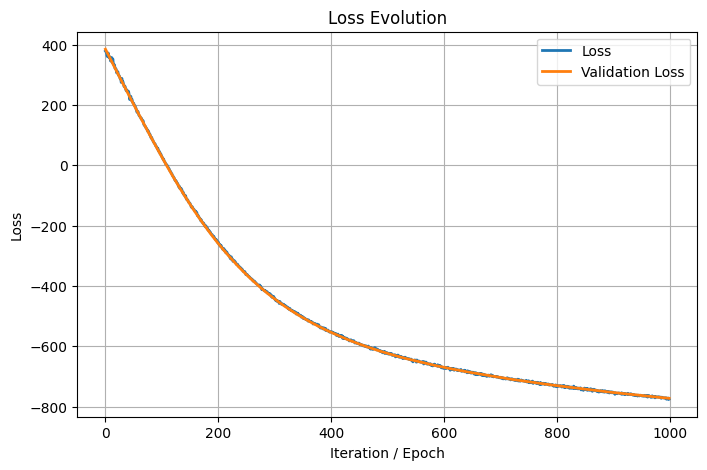

In [98]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']
            
# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [99]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))

254 254


In [11]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  6%|▌         | 61/1000 [00:00<00:10, 93.07it/s] 


In [12]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

  5%|▌         | 51/1000 [00:01<00:20, 46.46it/s]


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [100]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [101]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [102]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.5827
KLD Gaussian Train Data:  0.1123
KLD Copula   Train Data:  0.0014
KLD GTM      Test  Data:  0.5773
KLD Gaussian Test  Data:  0.1141
KLD Copula   Test  Data:  0.0008


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [103]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

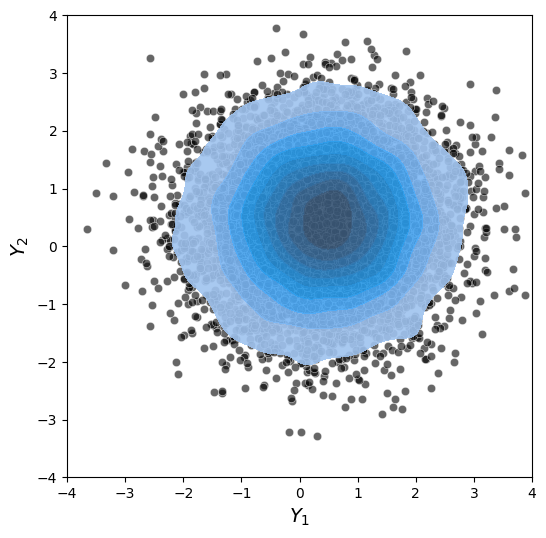

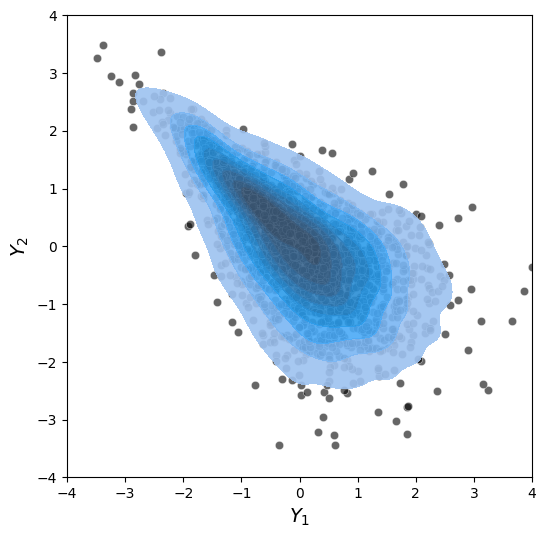

In [104]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [88]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-clean/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/Users/franciscocapunay/miniforge3/envs/gtm-clean/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


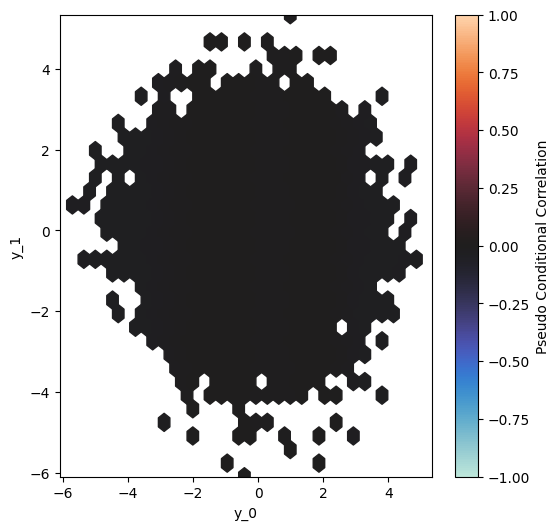

In [89]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


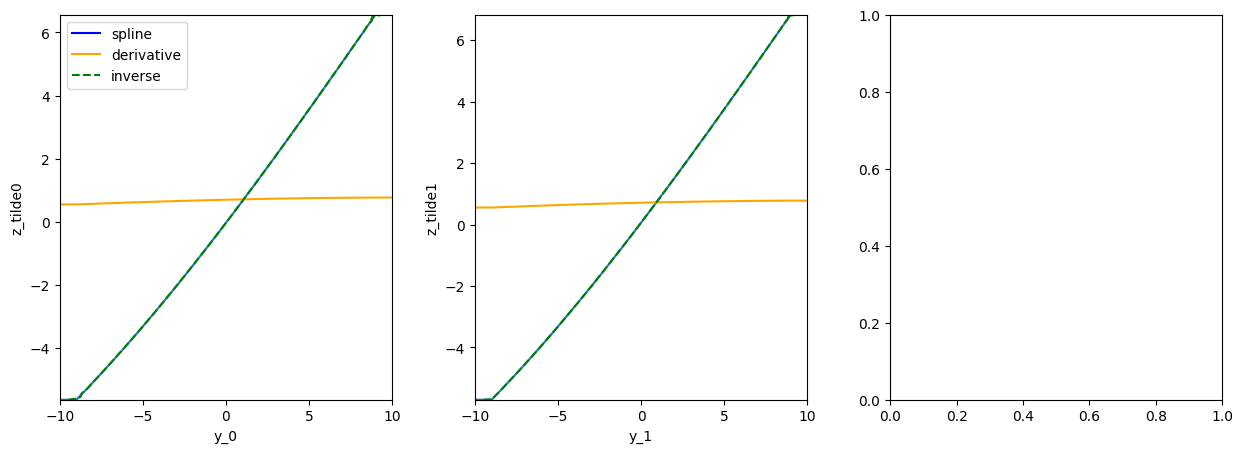

In [90]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


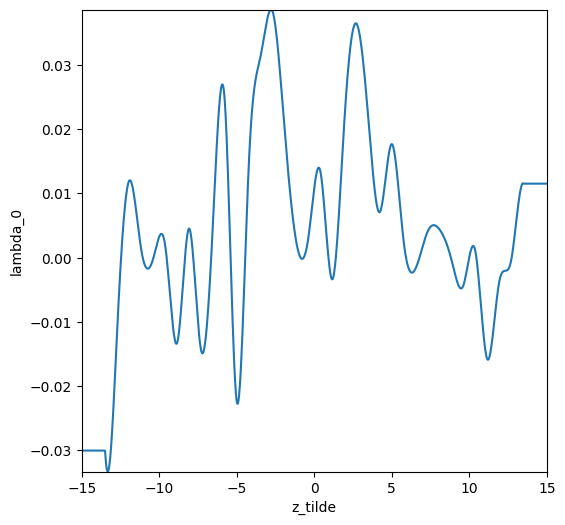

In [91]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [92]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

ValueError: decorrelation_layer_number exceeds the number of decorrelation layers.

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:184: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


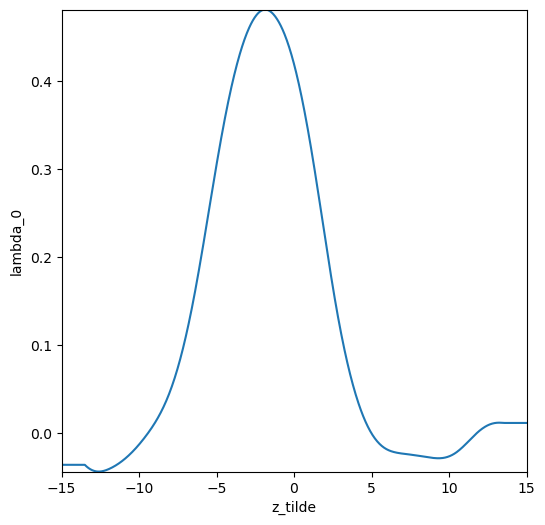

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)